# **BERTology**

My task for today is to train the classifier on tasks from `GLEU` dataset. The goal is to set experiments and achieve the best score of the metric relevant to the task.

In this notebook I'll use the `Hugging Face's` transformers library to fine-tune pretrained **BERT** models. I will compare the different approaches to training classifier, backing up each with commentary and metric score. 

# **1. SST-2**

The first dataset I will consider is **SST-2**. Phrases with fine-grained sentiment labels in the parse trees of sentences from movie reviews. Models performances are evaluated on a binary classification (positive, negative) model based on accuracy.

## **1.1 Data research**


The first thing we need to do is to load the `Hugging Face` libraries with data and models.

In [ ]:
!pip install datasets transformers

In [2]:
from datasets import load_dataset
from datasets import ClassLabel, Sequence
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore') 

%matplotlib inline

Due to limited resources, I will download only part of the dataset.

In [ ]:
train_dataset = load_dataset('glue', 'sst2', split='train[5%:45%]')
valid_dataset = load_dataset('glue', 'sst2', split='train[:5%]+train[45%:50%]')
test_dataset = load_dataset('glue', 'sst2', split='validation')

In [4]:
print("Length of datasets:")
print(f"Train: {len(train_dataset)}", f"Valid: {len(valid_dataset)}", f"Test:  {len(test_dataset)}", sep = '\n')

Length of datasets:
Train: 26940
Valid: 6734
Test:  872


In [5]:
def dt_to_pd(dataset):
    """
    Сonvert from Dataset type to DataFrame.
    """
    df = pd.DataFrame(dataset)
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    return df

For convenient analysis of the sentences, let's translate the data into a DataFrame.

In [6]:
df_train = dt_to_pd(train_dataset)
df_valid = dt_to_pd(valid_dataset)
df_test = dt_to_pd(test_dataset)

In [7]:
data_nums = [df_train, df_valid, df_test]

In [8]:
df_train.sample(10)

,sentence,label,idx
11715,never settles into the light-footed enchantmen...,negative,15082
11104,puzzle his most ardent fans,negative,14471
22843,beautiful film to watch,positive,26210
14632,"infuses the movie with much of its slender , g...",positive,17999
23109,manages to instruct without reeking of researc...,positive,26476
21198,"memory , resistance and artistic transcendence",positive,24565
23683,the story and the actors are served with a hac...,negative,27050
13494,"very ugly , very fast",negative,16861
16518,a wonderfully creepy mood,positive,19885
14788,it 's not going to be everyone 's bag of popcorn,negative,18155


In [9]:
print("Number of NULL labels in data:")
print(f"Train: {df_train['label'].isnull().sum()}", f"Valid: {df_valid['label'].isnull().sum()}", f"Test:  {df_test['label'].isnull().sum()}", sep = '\n')

Number of NULL labels in data:
Train: 0
Valid: 0
Test:  0


In [10]:
def class_balances(datasets):
    """
    Plot distribution of class labels
    @params datasets (list): array containing all parts [train, val, test] of the dataset
    """
    fig, axes = plt.subplots(ncols=2, nrows=len(datasets), figsize=(16, 8), dpi=100)
    data = ['Train', 'Validation', 'Test']

    for i in range(len(datasets)):
        p = sns.countplot(datasets[i]['label'], ax=axes[i][0])
        p.set(ylabel = data[i], xlabel="")
        axes[i][1].pie(datasets[i]['label'].value_counts(),
            labels=['Negative', 'Positive'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60,
            radius = 1.2)
        
    fig.suptitle('Distribution of the class labels', fontsize=16)
    plt.show();

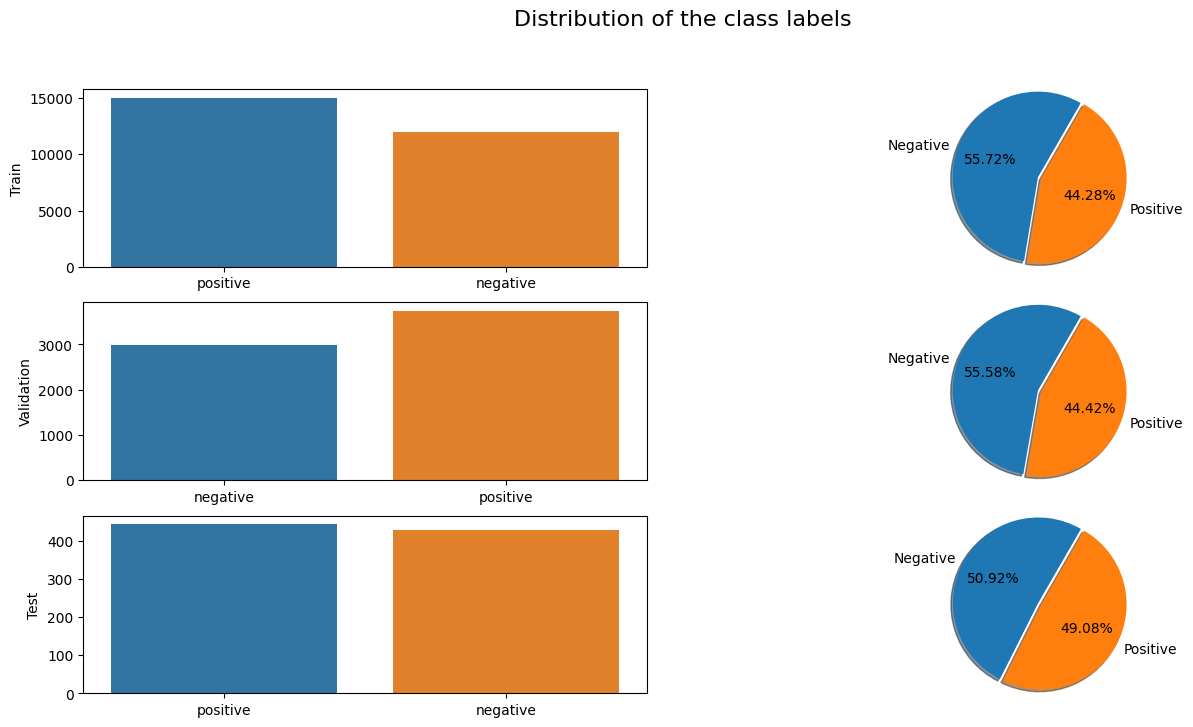

In [11]:
class_balances(data_nums)

Our classes are almost balanced, which means we get representative data and can proper classifier results.


In [12]:
def word_number(textno, textye):
    """
    Plot comparing different class sentences word counts
    """
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8),  dpi=100)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0])
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1])
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Negative sentences')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('Positive sentences')
    
    fig.suptitle('Words Per Sentence in Train', va='baseline')
    fig.tight_layout();

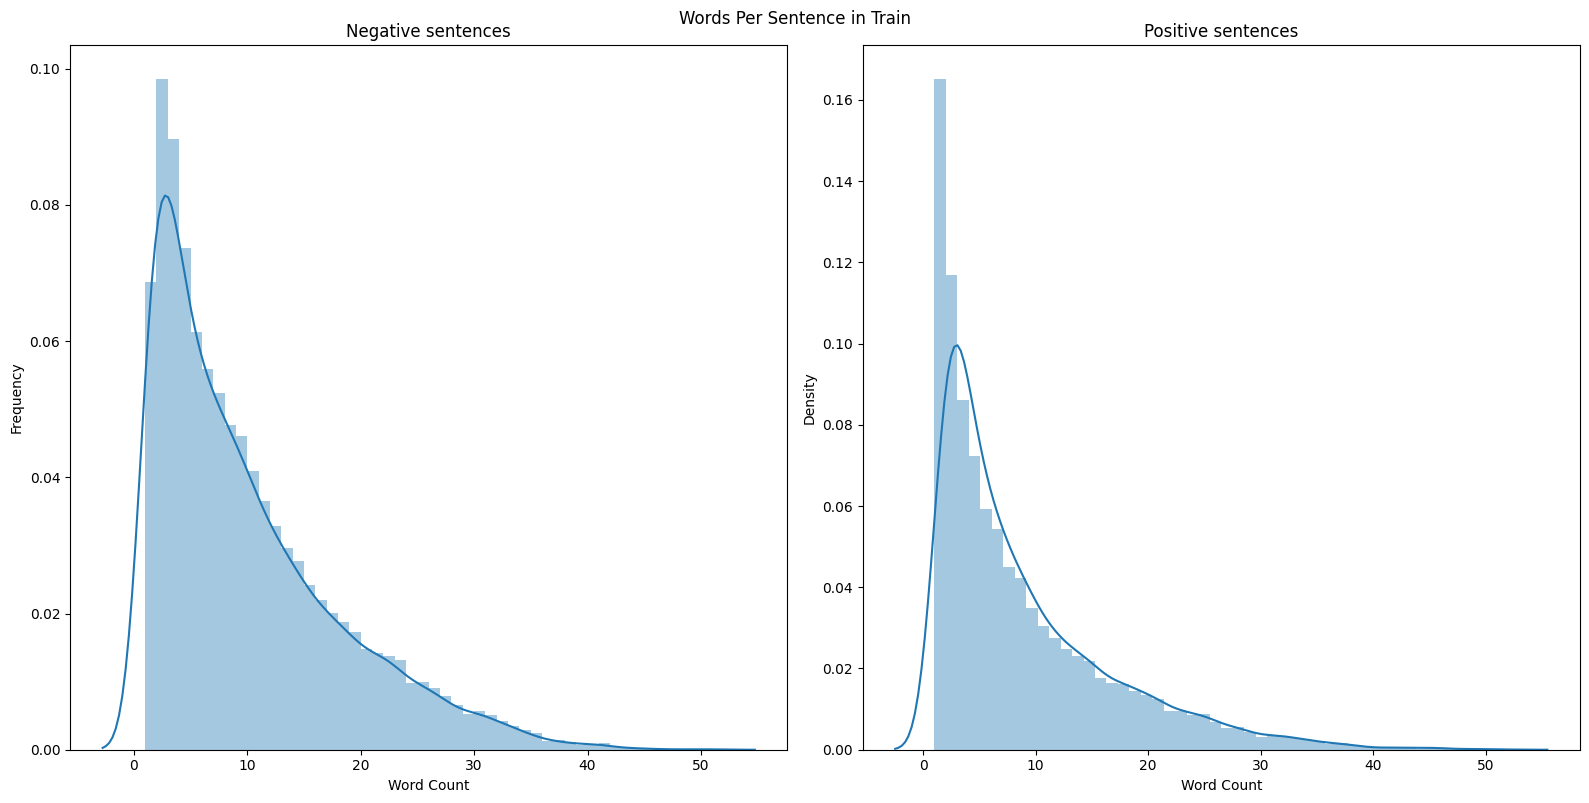

In [13]:
word_number(df_train[df_train['label'] == 'negative']['sentence'],
            df_train[df_train['label'] == 'positive']['sentence'])

According to the distribution of the number of words in the sentences corresponding to the different classes, we can notice that most of the sentences in train data don't exceed 20 characters.

In [14]:
def words_in_sentences(datasets):
    """
    A function for counting word counts in sentences.
    """
    fig, axes = plt.subplots(ncols=len(datasets), nrows=1, figsize=(18, 6), dpi=100)
    
    for i in range(len(datasets)):  
        sns.histplot([len(datasets[i]["sentence"][j].split()) for j in range(len(datasets[i]))], 
                     ax=axes[i], 
                     multiple="stack", 
                     palette="Blues_r", 
                     edgecolor=".3", 
                     linewidth=.5,)
        axes[i].set_xlabel("Number of words in sentence")
        axes[0].set_ylabel("Number of samples")

    fig.suptitle("Sentence Length Distribution", va='baseline', fontsize=15)
    axes[0].set_title("Train")
    axes[1].set_title("Validation")
    axes[2].set_title("Test")

    plt.show();

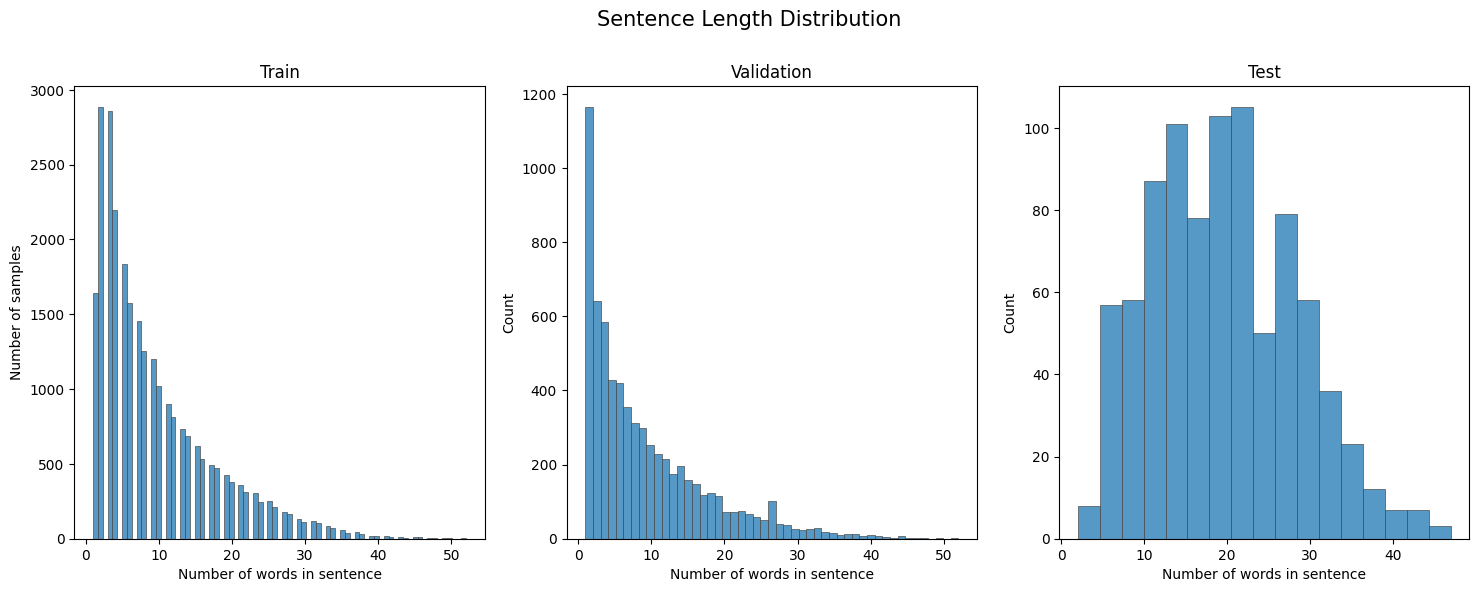

In [15]:
words_in_sentences(data_nums)

In the given train and validation data sentences of up to 20 words have the advantage, while the test data samples looks more varied in terms of length.

In [16]:
def max_sentence_len(data):
    """
    Calculating the maximum sentence length in the data
    @params data (list): array containing all parts [train, val, test] of the dataset
    """
    max_snt = []
    for i in range(len(data)):
        max_snt.append(max([len(data[i]["sentence"][j].split()) for j in range(len(data[i]))]))
        
    return max(max_snt)

In [17]:
max_len = max_sentence_len(data_nums)
print("Max sentence length:", max_len)

Max sentence length: 52


Maximum length will be required for tokenizing sentences. The model can only accept fixed length sentences as input, we will add short sentences with `<PAD>`

## **1.2 First Approach**

+ The first approach consists of extracting features by running the dataset through a pre-trained **BERT**, and then training classical machine learning classifiers such as: **Logistic Regression, Randon Forest, SVM** on these features.
+ In order to apply the pre-trained **BERT**, we must use the tokenizer provided by the library. This is because the model has a specific, fixed vocabulary and the BERT tokenizer has a particular way of handling out-of-vocabulary words.
+ In this point I took [Roberta Base SST-2](https://huggingface.co/textattack/roberta-base-SST-2) as a pre-trained model, I looked into the [benchmark](https://paperswithcode.com/sota/text-classification-on-glue) and decided to use the leading one in the metric relevant to our task - accuracy.


In [ ]:
!pip install scikit-plot

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, logging
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import scikitplot.metrics as splt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

logging.set_verbosity_error()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("textattack/roberta-base-SST-2")
model = AutoModelForSequenceClassification.from_pretrained("textattack/roberta-base-SST-2")

In [21]:
all_data = [train_dataset, valid_dataset, test_dataset] 

We are required to tokenize our sentences, add special tokens to the start `[CLS]` and end `[SEP]` of each of them, pad & truncate all sentences to a single constant length `max_len`, and explicitly specify what are padding tokens with the "attention mask".

In [22]:
def encode(examples):
    """
    Perform required preprocessing steps for pretrained BERT
    """
    return tokenizer(examples["sentence"], truncation=True, padding='max_length', max_length=max_len)

Preprocess function below is based on the `HuggingFace` notes.

In [23]:
def preprocess(data):
    """
    Correcting data for model input
    @params data(list): array containing all parts [train, val, test] of the dataset
    """
    data = data.remove_columns(["idx", "sentence"])
    data = data.rename_column("label", "labels")
    data = data.with_format("torch")
    return data

In [24]:
train_enc, valid_enc, test_enc = map(preprocess, list(item.map(encode, batched=True) for item in all_data))

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now that our data have been reduced to the required form, we can see what the data description consists of:

In [25]:
train_enc.features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None)}

In [26]:
print('Orginal text: ', train_dataset["sentence"][0], end='\n')
sample = train_enc['input_ids'][0]
print('Tokenized text:', sample, end='\n')
print('Detokenized text:', tokenizer.decode(sample), end='\n')

Orginal text:  the creative animation work may not look as fully ` rendered ' as pixar 's industry standard , but it uses lighting effects and innovative backgrounds to an equally impressive degree . 
Tokenized text: tensor([    0,   627,  3904, 19269,   173,   189,    45,   356,    25,  1950,
        22209, 18728,   128,    25,   181,  3181,   271,   128,    29,   539,
         2526,  2156,    53,    24,  2939,  7526,  3038,     8,  5497, 14218,
            7,    41,  6681,  3444,  3093,   479,  1437,     2,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1])
Detokenized text: <s>the creative animation work may not look as fully ` rendered'as pixar's industry standard, but it uses lighting effects and innovative backgrounds to an equally impressive degree. </s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


As we can see there is an `<s>`==`[CLS]` token at the beginning of the sentence, which will contain information about the context of the whole sentence after the self-attention layers. It is around this token that all our future work will be built.

In [27]:
BATCH_SIZE = 16 #this batch_size was proposed by the author of the model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [28]:
train_dataloader = DataLoader(
    train_enc, shuffle=True, batch_size = BATCH_SIZE
    )

eval_dataloader = DataLoader(
    valid_enc, batch_size = BATCH_SIZE
    )

test_dataloader = DataLoader(
    test_enc, batch_size = BATCH_SIZE
)

From the loaded model we need the part that doesn't contain the classifier.

In [29]:
model = model.roberta.to(DEVICE)

In [30]:
def get_hidden_state(model, dataloader, eval=False, task='SST'):
    """
    Calculation of the hidden pretrained model layer for the data
    """
    features = []
    labels = []

    with torch.no_grad():
        if eval:
            model.eval()
        for batch in tqdm(dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            batch_labels = batch["labels"].cpu().numpy()
            if task == 'RTE':
                outputs = model(batch["input_ids"], batch["attention_mask"], batch["token_type_ids"])
            else:
                outputs = model(batch["input_ids"], batch["attention_mask"])
            batch_features = outputs[0][:, 0, :].cpu().numpy()
            labels.append(batch_labels)
            features.append(batch_features)

    return (np.concatenate(features, axis=0), 
           np.concatenate(labels, axis=0))

`outputs[0][:, 0, :]` this command gets us the information that was received by the `[CLS]` token.

In [31]:
train_features, train_labels = get_hidden_state(model, train_dataloader)
eval_features, eval_labels = get_hidden_state(model, eval_dataloader, eval=True)

  0%|          | 0/1684 [00:00<?, ?it/s]

  0%|          | 0/421 [00:00<?, ?it/s]

The work with the **BERT** model in this approach is finished. We have obtained a new feature representation, which we will now feed into classical machine learning methods.

In [32]:
train_features.shape

(26940, 768)

The first thing to do is to apply **PCA** to the obtained representation, in order to lower the dimensionality.

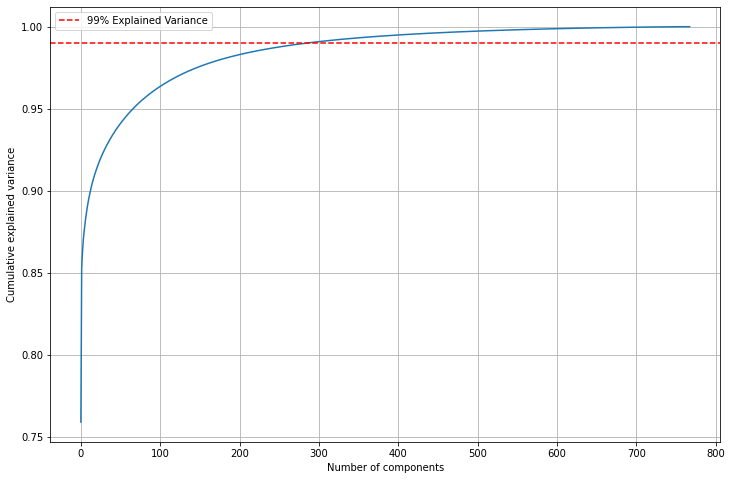

In [33]:
pca = PCA().fit(train_features)

plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.axhline(y = 0.99, color='r', linestyle='--', label = '99% Explained Variance')
plt.legend(loc='best')
plt.grid()

We can notice that `n_components = 500` covers almost 100% of the explained variance, so let's use this. \
Let's start the comparison of classifiers with **Logistic Regression**. To avoid data leaks, we use the `pipeline`.

In [34]:
pca = PCA(n_components=500)
log_reg = LogisticRegression()

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('logreg', log_reg)
])

params_grid = [
    {'logreg__penalty': ['l1', 'l2', 'elaticnet', 'none'],
    'logreg__C': np.logspace(-4, 4, 20),
    }
]

We use `GridSearchCV` to select parameters according to the grid.

In [35]:
clf = GridSearchCV(pipeline, param_grid = params_grid, cv=3, verbose=True, n_jobs=-1)
best_pca = clf.fit(train_features, train_labels)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


In [36]:
best_pca.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=500)),
                ('logreg', LogisticRegression(C=0.012742749857031334))])

On the validation data let's evaluate the quality of the obtained classifier.

In [37]:
print('F1-score: ', f1_score(eval_labels, best_pca.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, best_pca.predict(eval_features)))

F1-score:  0.9695187165775401
Accuracy:  0.9661419661419661


The next classifier is **Random Forest**. Let's try to see with our own eyes how the quality of classification changes depending on the number of `n_estimators`

In [38]:
f1 = []
accr = []

for i in tqdm(np.arange(1, 51)):
    best_rndm_frst = RandomForestClassifier(n_estimators = i)
    best_rndm_frst.fit(train_features, train_labels)
    
    f1.append(f1_score(eval_labels, best_rndm_frst.predict(eval_features)))
    accr.append(accuracy_score(eval_labels, best_rndm_frst.predict(eval_features)))

  0%|          | 0/50 [00:00<?, ?it/s]

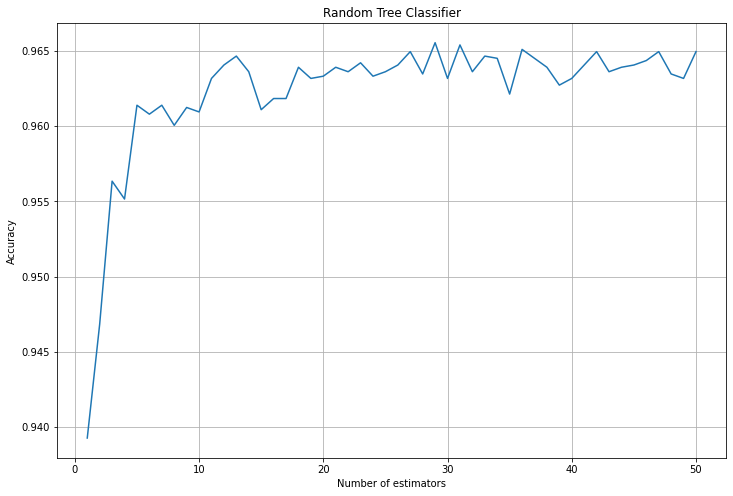

In [40]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 51), accr)

plt.xlabel('Number of estimators')
plt.title('Random Tree Classifier')
plt.ylabel('Accuracy')
plt.grid()
plt.show();

In [41]:
print("The best results are achieved with :", accr.index(max(accr)), "n_estimators.")

The best results are achieved with : 28 n_estimators.


Let's fit it!

In [42]:
rndmf = RandomForestClassifier(n_estimators = 28)
rndmf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=28)

On the validation data let's evaluate the quality of the obtained classifier.

In [43]:
print('F1-score: ', f1_score(eval_labels, rndmf.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, rndmf.predict(eval_features)))

F1-score:  0.9684238694139685
Accuracy:  0.9649539649539649


Next is the **Support Vectore Machine**. Again we use `GridSearchCV` to find the optimal parameters.


In [44]:
svm = SVC()

params_grid = [
    {
     'kernel': ['poly', 'rbf', 'sigmoid'],
    }
]

In [45]:
clf = GridSearchCV(svm, param_grid = params_grid, cv = 3, verbose=True, n_jobs=-1)
best_svm = clf.fit(train_features, train_labels)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [46]:
best_svm.best_estimator_

SVC()

In [47]:
print('F1-score: ', f1_score(eval_labels, best_svm.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, best_svm.predict(eval_features)))

F1-score:  0.9679743795036029
Accuracy:  0.9643599643599644


After training the three classifiers on the data obtained in the feature space issued by `BERT` model, we can see that the best result on the validation data showed **Logistic Regression** with **PCA**. \
Let's run the test data on it to see the final result of the metric.

In [48]:
test_features, test_labels = get_hidden_state(model, test_dataloader, eval=True)

  0%|          | 0/55 [00:00<?, ?it/s]

In [49]:
print('Accuracy: ', accuracy_score(test_labels, best_pca.predict(test_features)))

Accuracy:  0.9461009174311926


**Summary**: In the current approach, we achieved **94%** quality on test data by training the classifier using classical machine learning methods.

## **1.3 Another Approach**

+ The second approach consists of training the classifier as a neural network by back propagation of error. 
+ In the first stage, we will try to run the model "out of the box" to see its quality. Then we change classifier and will unfreeze it is. At the end we will unfreeze the weights of the whole model to throw the gradients to the first layer.
+ In this point I took [DistilBert finetuned SST-2](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) as a pre-trained model, it is a very popular model that achieved an accuracy of 91.3 on the dev set.


In [50]:
import torch.nn.functional as F
from datasets import load_metric
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from transformers import get_scheduler, AdamW
from transformers.modeling_outputs import SequenceClassifierOutput
import random
import time

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

In [52]:
metric = load_metric("glue", "sst2")

In [53]:
train_enc, valid_enc, test_enc = map(preprocess, list(item.map(encode, batched=True) for item in all_data))

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [54]:
BATCH_SIZE = 32 #from hugging-face description of model

In [55]:
train_dataloader = DataLoader(
    train_enc, shuffle=True, batch_size = BATCH_SIZE
    )

eval_dataloader = DataLoader(
    valid_enc, batch_size = BATCH_SIZE
    )

test_dataloader = DataLoader(
    test_enc, batch_size = BATCH_SIZE
)

### **1.3.1 "Out of the box" model**

In [56]:
model.to(DEVICE)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [57]:
def test_logits(model, test_dataloader, metric, task='SST'):
    """
    Perform a forward pass on the trained BERT model to predict probabilities on the test set.
    """
    model.eval()
    real_values = []
    probs = []
    preds = []

    for batch in tqdm(test_dataloader):
        b_input_ids = batch["input_ids"].to(DEVICE)
        b_attn_mask = batch["attention_mask"].to(DEVICE)
        b_labels = batch["labels"].to(DEVICE)

        with torch.no_grad():
            if task == 'RTE':
                b_token_type = batch["token_type_ids"].to(DEVICE)
                outputs = model(b_input_ids, b_attn_mask, b_token_type)
            else:
                outputs = model(b_input_ids, b_attn_mask) 

            if isinstance(outputs, SequenceClassifierOutput):
                logits = outputs.logits
            else:
                logits = outputs

            _, predictions = torch.max(logits, dim=1)
            metric.add_batch(predictions=predictions, references=b_labels)

        preds.extend(predictions)
        real_values.extend(b_labels)
        probs.extend(logits)

    preds = torch.stack(preds).cpu()
    real_values = torch.stack(real_values).cpu()
    probs = torch.stack(probs).cpu()

    return preds, probs, real_values, metric

In [58]:
preds, probs, labels, metric = test_logits(model, eval_dataloader, metric)

  0%|          | 0/211 [00:00<?, ?it/s]

Let's take a look at the metric value from the HuggingFace interface to "out of box" model.

In [59]:
print("Out of the box model - accuracy score: " , metric.compute()["accuracy"] * 100)

Out of the box model - accuracy score:  98.82684882684882


In [60]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC on the test set
    - Plot ROC
    """
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 6), dpi=100)

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()

    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.show();

In [61]:
def show_confusion_matrix(confusion_matrix):
    """
    Plot confusion matrix of classes
    """
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(10, 6), dpi=100)
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

For a more detailed analysis, let's plot the ROC and confusion matrix.

AUC: 0.9987


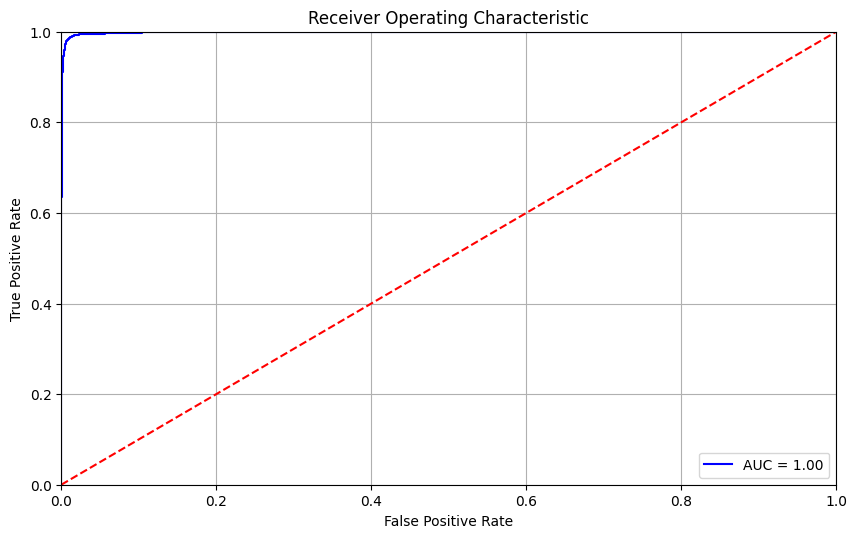

In [62]:
evaluate_roc(probs, labels)

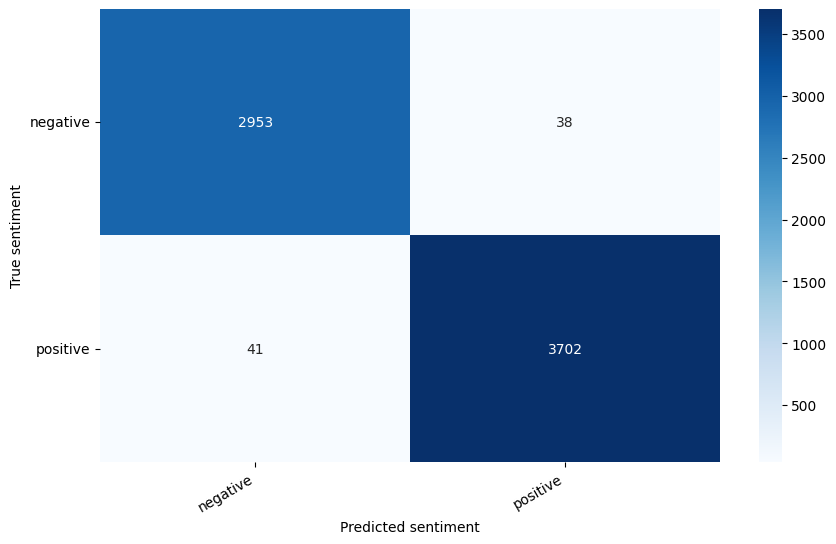

In [63]:
class_names = ['negative', 'positive']
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

We can see that the model predicts well, let's move on to experiments with the classifier.

### **1.3.2 Trainee model**

In [64]:
class SentenceClassifier(nn.Module):
    """
    Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(SentenceClassifier, self).__init__()

        D_in, H, D_out = 768, 256,  2

        self.bert = model.distilbert
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.SELU(),
            nn.Dropout(),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

At forward step we highlight again `outputs[0][:, 0, :]` because this command gets us the information that was received by the `[CLS]` token.

In [65]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

Training code below is based on the `run_glue.py` script [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128)

In [66]:
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader, val_dataloader, epochs=4, task='SST'):
    """
    Train the Bert Classifier model.
    """
    print("Start training...\n")

    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []

    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0
        accuracy = 0

        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids = batch["input_ids"].to(DEVICE)
            b_attn_mask = batch["attention_mask"].to(DEVICE)
            b_labels = batch["labels"].to(DEVICE)

            model.zero_grad()

            if task == 'RTE':
                b_token_type = batch["token_type_ids"].to(DEVICE)
                logits = model(b_input_ids, b_attn_mask, b_token_type) 
            else:
                logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()


            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            preds = torch.argmax(logits, dim=1).flatten()
            accuracy += (preds == b_labels).cpu().numpy().mean()

            if (step % 200 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accr = accuracy / len(train_dataloader)
        train_loss_values.append(avg_train_loss)
        train_acc_values.append(avg_train_accr * 100)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        val_loss, val_accuracy = evaluate(model, val_dataloader, task)

        val_loss_values.append(val_loss)
        val_acc_values.append(val_accuracy)

        time_elapsed = time.time() - t0_epoch
            
        print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_loss_values, train_acc_values, val_loss_values, val_acc_values


def evaluate(model, val_dataloader, task):
    """
    After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        b_input_ids = batch["input_ids"].to(DEVICE)
        b_attn_mask = batch["attention_mask"].to(DEVICE)
        b_labels = batch["labels"].to(DEVICE)

        with torch.no_grad():
            if task == 'RTE':
                b_token_type = batch["token_type_ids"].to(DEVICE)
                logits = model(b_input_ids, b_attn_mask, b_token_type)
            else:
                logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [67]:
def learning_curve(data):
    """
    Plot training and validation curves of loss and accuracy
    @params data (list): array containing all parts [train_loss, val_loss, train_accr, val_accr] of training
    """
    fig, axes = plt.subplots(ncols=2, nrows= 1, figsize=(12, 6), dpi=100)

    for j , i in enumerate(range(0, 3, 2)):
        axes[j].plot(data[i], 'b-o', label='Training')
        axes[j].plot(data[i+1], 'g-o', label='Validation')
        axes[j].set_xlabel('Epoch')
        axes[j].legend()
        axes[j].grid()

    fig.suptitle("Training & Validation Curves", va='baseline')

    axes[0].set_ylabel('Count')
    axes[1].set_title('Accuracy')
    axes[0].set_title('Loss')

    plt.show();

So, we replaced the classifier in the original `BERT`, it's time to train it with freezing the `BERT` weights. The parameters below were voiced by the author of the model in the description on `Hugging Face`.

In [68]:
new_classifier = SentenceClassifier(freeze_bert=True)

optimizer = AdamW(new_classifier.parameters(), lr = 1e-5)

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

new_classifier.to(DEVICE)

SentenceClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

In [69]:
set_seed(42)    # Set seed for reproducibility
train_loss, train_accuracy, val_loss, val_accuracy = train(new_classifier, train_dataloader, eval_dataloader, epochs=epochs)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.150604   |     -      |     -     |   21.87  
   1    |   400   |   0.055441   |     -      |     -     |   21.56  
   1    |   600   |   0.042849   |     -      |     -     |   21.73  
   1    |   800   |   0.037528   |     -      |     -     |   21.77  
   1    |   841   |   0.068968   |     -      |     -     |   4.46   
----------------------------------------------------------------------
   1    |    -    |   0.071571   |  0.042128  |   98.82   |  113.38  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   200   |   0.041682   |     -      |     -     |   21.89  
   2    |   400   |   0.050945   |     -      |     -     |   21.

So, we trained the classifier and achieved **98.83%** accuracy on the validation data, for more detailed results let's look at the graphs.

In [70]:
train_results_sst = [train_loss, val_loss, train_accuracy, val_accuracy]

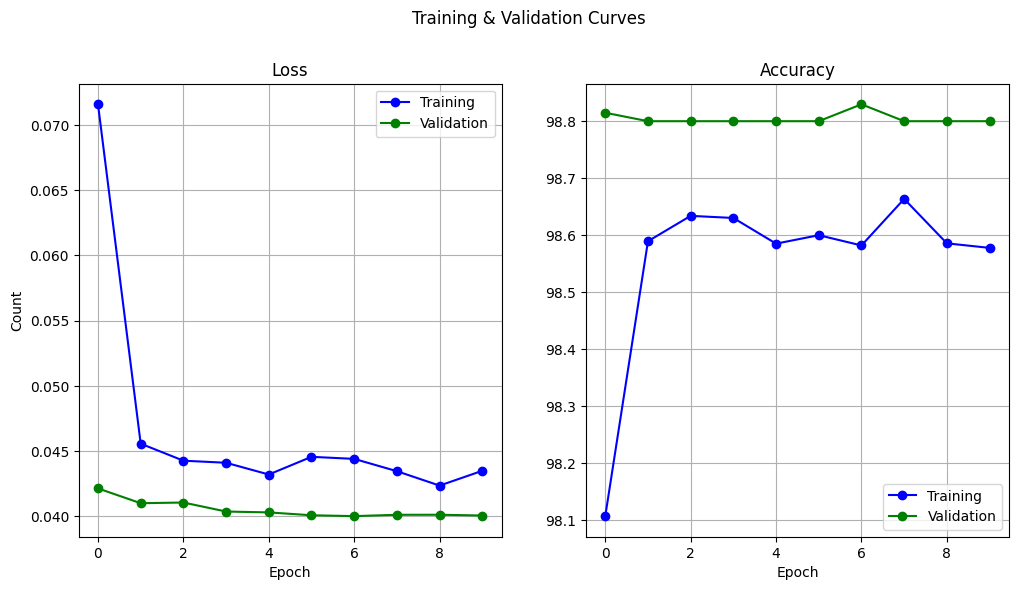

In [71]:
learning_curve(train_results_sst)

It seems that the training is correct.

In [72]:
preds, probs, labels, _ = test_logits(new_classifier, eval_dataloader, metric)


  0%|          | 0/211 [00:00<?, ?it/s]

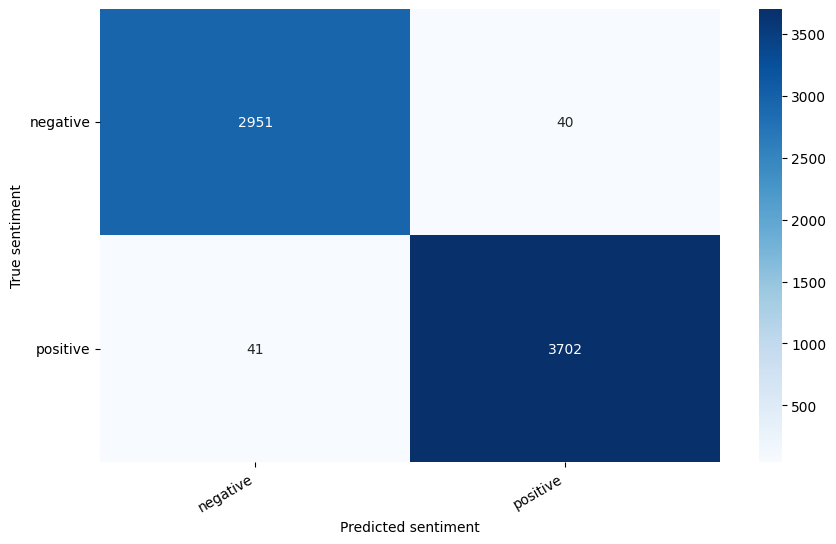

In [73]:
class_names = ['negative', 'positive']
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

It's not a bad model, but it's too early to stop there! \
Now we will teach not only the classifier, but all weights.

In [74]:
learn_all = SentenceClassifier(freeze_bert=False)

optimizer = AdamW(learn_all.parameters(), lr = 1e-5)

epochs = 7

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

learn_all.to(DEVICE)

SentenceClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

In [75]:
train_loss, train_accuracy, val_loss, val_accuracy = train(learn_all, train_dataloader, eval_dataloader, epochs=epochs)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.143390   |     -      |     -     |   25.62  
   1    |   400   |   0.054348   |     -      |     -     |   22.09  
   1    |   600   |   0.045346   |     -      |     -     |   26.21  
   1    |   800   |   0.051128   |     -      |     -     |   22.83  
   1    |   841   |   0.051583   |     -      |     -     |   4.46   
----------------------------------------------------------------------
   1    |    -    |   0.072566   |  0.042369  |   98.77   |  123.63  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   200   |   0.044172   |     -      |     -     |   21.92  
   2    |   400   |   0.043392   |     -      |     -     |   21.

We may notice that we achieved a little more accuracy on the validation set. Let's look!

In [76]:
train_results_sst = [train_loss, val_loss, train_accuracy, val_accuracy]

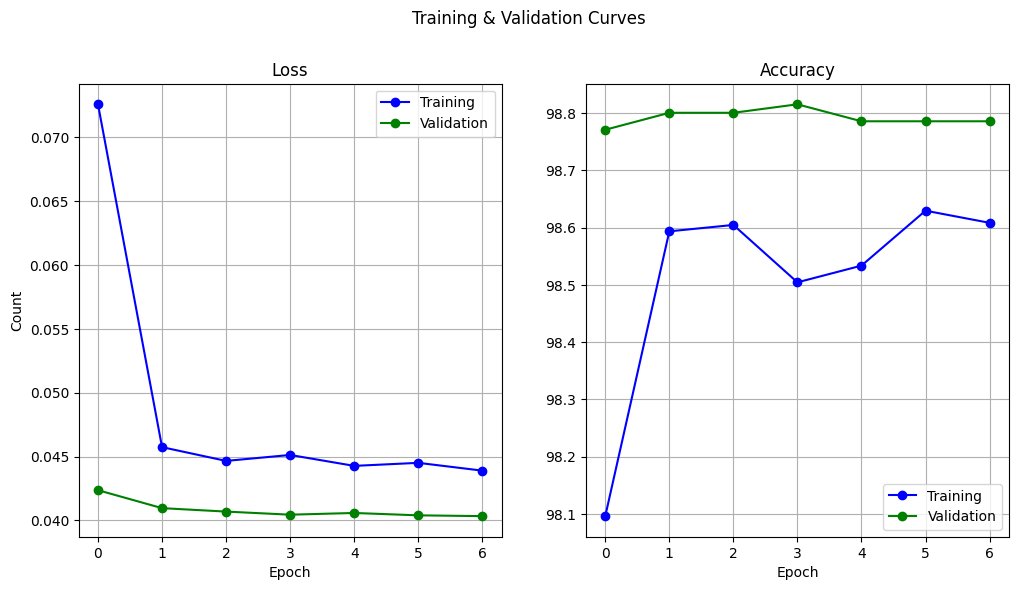

In [77]:
learning_curve(train_results_sst)

The plots reflect the correct learning.

In [78]:
preds, probs, labels, _ = test_logits(learn_all, eval_dataloader, metric)

  0%|          | 0/211 [00:00<?, ?it/s]

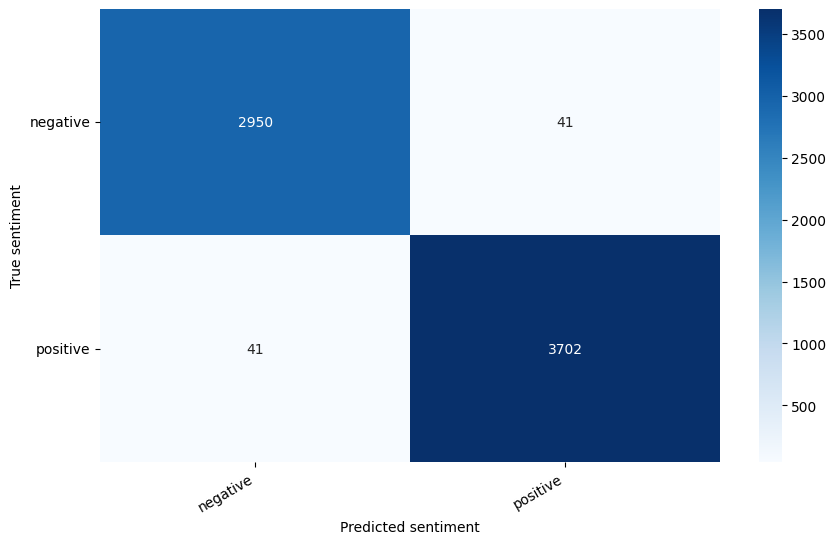

In [79]:
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Now let's look at the value of the metric on test data on more successful model.

In [80]:
_, probs, labels, metric = test_logits(learn_all, test_dataloader, metric)

  0%|          | 0/28 [00:00<?, ?it/s]

In [81]:
print("Trainee model - accuracy score: " , metric.compute()["accuracy"] * 100)

Trainee model - accuracy score:  98.28451882845188


AUC: 0.9723


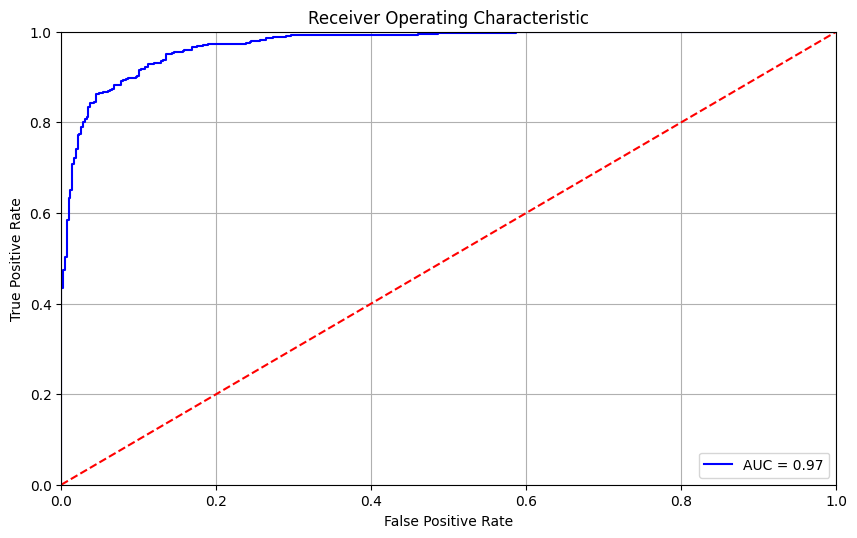

In [82]:
evaluate_roc(probs, labels)

## **1.4** **Brief summary**

I did some experiments on training a classifier for the classification problem on SST-2 data from the `GLUE` dataset. Each of the methods shown, showed competitive results and has its advantages and disadvantages. \
In my tests, the best result of accuracy metric **98.28%** was shown by **Distil Bert** model with modified classifier and unfrozen weights, **LogReg** on "Bert-made" features showed **94%**.

# **2. RTE**

The Recognizing Textual Entailment datasets come from a series of annual textual entailment challenges. Examples are constructed based on news and Wikipedia text. The Recognizing Textual Entailment (RTE) Datasets are combined and converted to two-class classification: *entailment* and *not entailment* with accuracy metric.

## **2.1 Data Research**

Let's divide the data into three parts.

In [ ]:
train_dataset = load_dataset('glue', 'rte', split='train[5%:45]+train[55%:95%]')
valid_dataset = load_dataset('glue', 'rte', split='train[:5%]+train[45%:55%]+train[-5%:]')
test_dataset = load_dataset('glue', 'rte', split='validation')

In [84]:
print("Length of datasets:")
print(f"Train: {len(train_dataset)}", f"Valid: {len(valid_dataset)}", f"Test:  {len(test_dataset)}", sep = '\n')

Length of datasets:
Train: 1992
Valid: 498
Test:  277


For convenient analysis of the sentences, let's translate the data into a DataFrame.

In [85]:
df_train = dt_to_pd(train_dataset)
df_valid = dt_to_pd(valid_dataset)
df_test = dt_to_pd(test_dataset)

In [86]:
data_nums = [df_train, df_valid, df_test]

In [87]:
df_train.sample(10)

,sentence1,sentence2,label,idx
887,Ministers of the Association of Southeast Asia...,Ministers of the Association of Southeast Asia...,not_entailment,1011
1671,The participation of women in parliament in Ma...,Women are poorly represented in parliament.,not_entailment,2045
414,The longest stay in space was 438 days by Vale...,"The record for the longest stay in space, by a...",entailment,538
1080,"Albert Sabin developed an oral, attenuated (li...",Polio is under control in the world.,entailment,1454
1102,The Dalai Lama has offered to send 50 trained ...,The Dalai Lama has been living in exile since ...,not_entailment,1476
998,"Today, Dmitry Medvedev was named the candidate...",Vladimir Putin does not support Medvedev.,not_entailment,1372
1927,The Industrial and Commercial Bank of China Lt...,The merger of Japanese Banks creates the world...,not_entailment,2301
1966,"Heavy rain flooded parts of the site, with doz...",100 tents had been washed away.,not_entailment,2340
767,The prosecutor told the court that the inciden...,"The prosecutor told the court that ""distress"" ...",entailment,891
1583,Among the 21 candidates left over after the pr...,Jennifer Lopez will not perform in Portugal.,not_entailment,1957


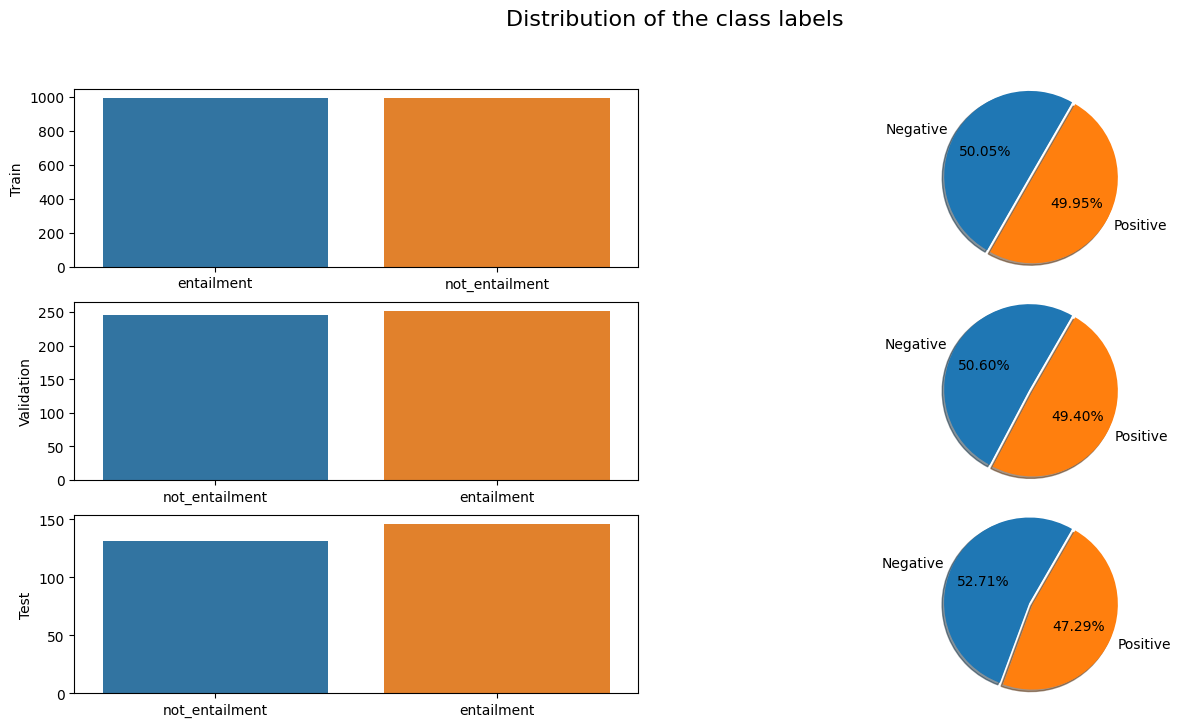

In [88]:
class_balances(data_nums)

Our classes are balanced, for the record, better than the SST, which means we get representative data and can proper classifier results.

In [89]:
def words_in_sentences_rte(datasets):
    """
    A function for counting word counts in sentences.
    """
    fig, axes = plt.subplots(ncols=len(datasets), nrows=2, figsize=(18, 6), dpi=100)
    
    for i in range(len(datasets)):  
        sns.histplot([len(datasets[i]["sentence1"][j].split()) for j in range(len(datasets[i]))], 
                     ax=axes[0][i], 
                     multiple="stack", 
                     palette="Blues_r", 
                     edgecolor=".3", 
                     linewidth=.5,)
        sns.histplot([len(datasets[i]["sentence2"][j].split()) for j in range(len(datasets[i]))], 
                     ax=axes[1][i], 
                     multiple="stack", 
                     palette="Blues_r", 
                     edgecolor=".3", 
                     linewidth=.5,)
        axes[1][i].set_xlabel("Number of words in sentence")
        axes[0][0].set_ylabel("Number of samples: sentence 1")
        axes[1][0].set_ylabel("Number of samples: sentence 2")

    fig.suptitle("Sentence Length Distribution", va='baseline', fontsize=15)
    axes[0][0].set_title("Train")
    axes[0][1].set_title("Validation")
    axes[0][2].set_title("Test")

    plt.show();

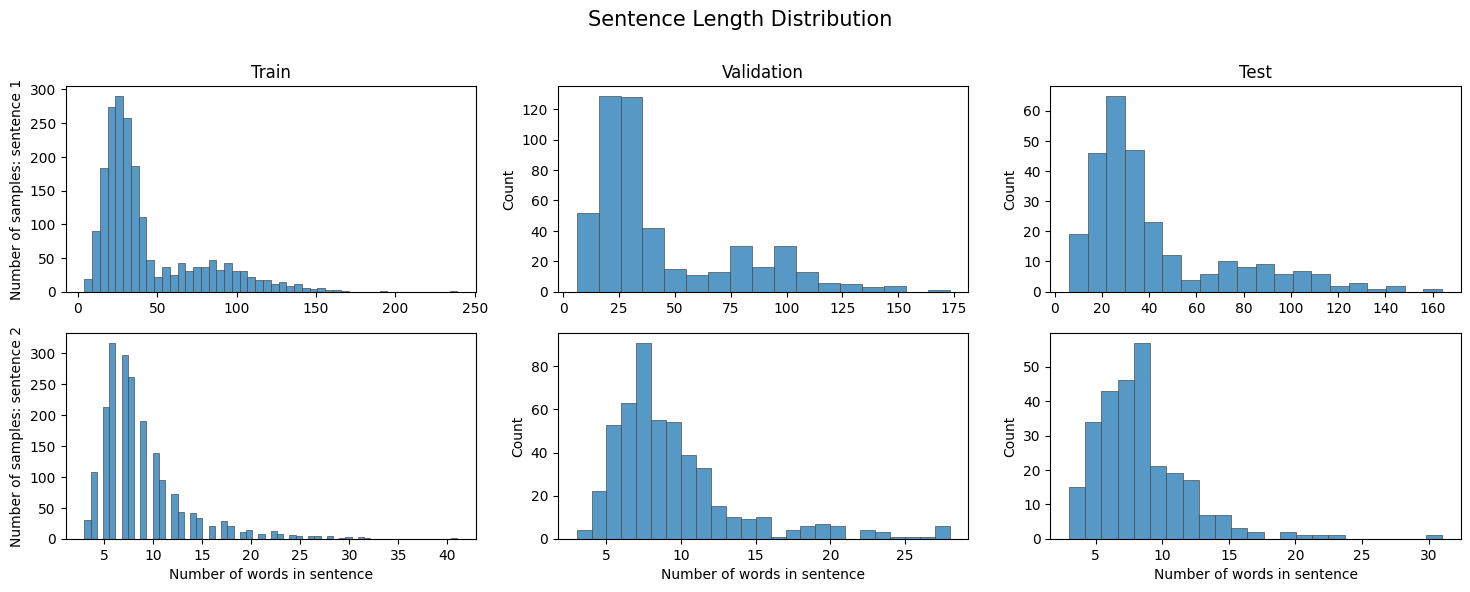

In [90]:
words_in_sentences_rte(data_nums)

In the data provided, in most of the first sentences the number does not exceed 50 words, and in the second 20. The test data look more varied in terms of length.

In [91]:
def max_sentence_len_rte(data):
    """
    Calculating the maximum sentence length in the data
    @params data (list): array containing all parts [train, val, test] of the dataset
    """
    max_snt1 = []
    max_snt2 = []
    for i in range(len(data)):
        max_snt1.append(max([len(data[i]["sentence1"][j].split()) for j in range(len(data[i]))]))
    for i in range(len(data)):
        max_snt2.append(max([len(data[i]["sentence2"][j].split()) for j in range(len(data[i]))]))
        
    return max(max_snt1), max(max_snt2)

In [92]:
max_len1, max_len2 = max_sentence_len_rte(data_nums)
print("Max sentence1 length:", max_len1)
print("Max sentence2 length:", max_len2)

Max sentence1 length: 239
Max sentence2 length: 41


Maximum length will be required for tokenizing sentences. The model can only accept fixed length sentences as input, we will add short sentences with `<PAD>`

## **2.2 First Approach**

+ The first approach consists of extracting features by running the dataset through a pre-trained **BERT**, and then training gradient boosting classifiers such as:** XGBoost, LightGBM** and **CatBoost** on these features. We will search for the best parameters on the grid.
+ In order to apply the pre-trained **BERT**, we must use the tokenizer provided by the library. This is because the model has a specific, fixed vocabulary and the BERT tokenizer has a particular way of handling out-of-vocabulary words.
+ In this point I took [Bert Base Uncased RTE](https://huggingface.co/yoshitomo-matsubara/bert-base-uncased-rte) as a pre-trained model, I looked into the benchmark and decided to use the leading one in the metric relevant to our task - accuracy.

In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [94]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("yoshitomo-matsubara/bert-base-uncased-rte")
model = AutoModelForSequenceClassification.from_pretrained("yoshitomo-matsubara/bert-base-uncased-rte")

In [96]:
all_data = [train_dataset, valid_dataset, test_dataset] 

We are required to tokenize our sentences, add special tokens to the start `[CLS]`, between `sentence1` and `sentence2` and at the end `[SEP]` of each of them, pad & truncate all sentences to a single constant length `max_len`, and explicitly specify what are padding tokens with the "attention mask". As the `max_len` the authors of the model suggest that we put 128. 

In [97]:
def encode_rte(examples):
    """
    Perform required preprocessing steps for pretrained BERT
    """
    return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True, padding='max_length', max_length=128)

In [98]:
def preprocess_rte(data):
    """
    Correcting data for model input
    @params data(list): array containing all parts [train, val, test] of the dataset
    """
    data = data.remove_columns(["idx", "sentence1", "sentence2"])
    data = data.rename_column("label", "labels")
    data = data.with_format("torch")
    return data

In [99]:
train_enc, valid_enc, test_enc = map(preprocess_rte, list(item.map(encode_rte, batched=True) for item in all_data))

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now that our data have been reduced to the required form, we can see what the data description consists of:

In [100]:
train_enc.features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=2, names=['entailment', 'not_entailment'], id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

We may notice here the `token_type_ids` key, which plays the role of separating sentences. The first is marked with one number, the second with another.

In [101]:
print('Orginal text: ', '1:', train_dataset["sentence1"][0], '2:', train_dataset["sentence2"][0], end='\n')
sample = train_enc['input_ids'][0]
print('Tokenized text:', sample, end='\n')
print('Detokenized text:', tokenizer.decode(sample), end='\n')

Orginal text:  1: Since the island also lacks wells, water has to be obtained from rain carefully collected in concrete cisterns. 2: The island gets water from collected rain.
Tokenized text: tensor([  101,  2144,  1996,  2479,  2036, 14087,  7051,  1010,  2300,  2038,
         2000,  2022,  4663,  2013,  4542,  5362,  5067,  1999,  5509, 20199,
        16451,  2015,  1012,   102,  1996,  2479,  4152,  2300,  2013,  5067,
         4542,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,

As we can see there is an `[CLS]` token at the beginning of the sentence, which will contain information about the context of the whole sentence after the self-attention layers. It is around this token that all our future work will be built.

In [102]:
BATCH_SIZE_TRAIN = 16 #this batch_size was proposed by the author of the model_selection
BATCH_SIZE_TEST = 32

In [103]:
train_dataloader = DataLoader(
    train_enc, shuffle=True, batch_size = BATCH_SIZE_TRAIN
    )

eval_dataloader = DataLoader(
    valid_enc, batch_size = BATCH_SIZE_TEST
    )

test_dataloader = DataLoader(
    test_enc, batch_size = BATCH_SIZE_TEST
)

From the loaded model we need the part that doesn't contain the classifier.

In [104]:
model = model.bert.to(DEVICE)

In [105]:
train_features, train_labels = get_hidden_state(model, train_dataloader, task='RTE')
eval_features, eval_labels = get_hidden_state(model, eval_dataloader, eval=True, task='RTE')

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

The work with the **BERT** model in this approach is finished. We have obtained a new feature representation, which we will now feed into classical machine learning methods.

In [106]:
train_features.shape

(1992, 768)

The first thing to do is to apply **PCA** to the obtained representation, in order to lower the dimensionality.

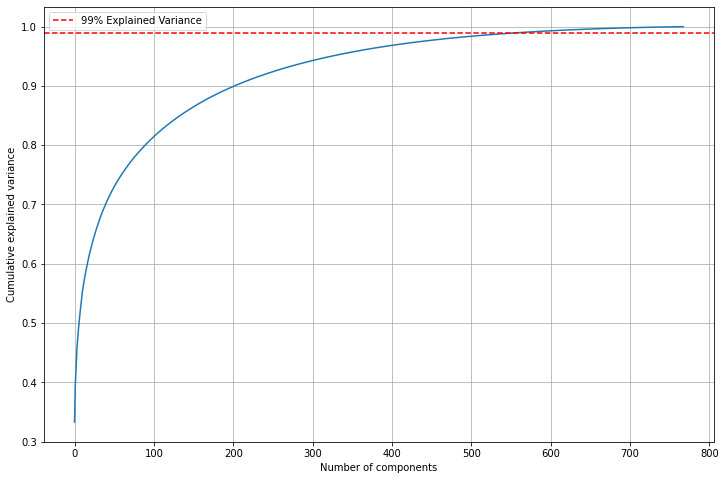

In [107]:
pca = PCA().fit(train_features)

plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.axhline(y = 0.99, color='r', linestyle='--', label = '99% Explained Variance')
plt.legend(loc='best')
plt.grid()

We can notice that `n_components = 600` covers almost 100% of the explained variance, so let's use this.
Let's start the comparison of GB classifiers with **XGBoost Classifier**. To avoid data leaks, we use the pipeline.

In [108]:
pca = PCA(n_components=600)
xg_boost = xgb.XGBClassifier(n_estimators=100, max_depth=5)

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('xg', xg_boost)
])

params_grid = [
    {
    'xg__learning_rate': np.arange(0.01, 0.21, 0.02),
    'xg__min_child_weight': [3, 5, 7, 9],
    }
]

We use `GridSearchCV` to select parameters according to the grid.

In [109]:
clf = GridSearchCV(pipeline, param_grid = params_grid, cv=3, verbose=True, n_jobs=-1)
best_xg = clf.fit(train_features, train_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [110]:
best_xg.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=600)),
                ('xg',
                 XGBClassifier(learning_rate=0.08999999999999998, max_depth=5,
                               min_child_weight=5))])

On the validation data let's evaluate the quality of the obtained classifier.

In [111]:
print('F1-score: ', f1_score(eval_labels, best_xg.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, best_xg.predict(eval_features)))

F1-score:  0.9421487603305786
Accuracy:  0.9437751004016064


The next classifier is **LightGBM**. In it, we will also search for parameters on the grid.

In [112]:
pca = PCA(n_components=600)
lgb_boost = lgb.LGBMClassifier(n_estimators=100)

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('lgb', lgb_boost)
])

params_grid = [
    {
    'lgb__learning_rate': np.arange(0.07, 0.21, 0.02),
    'lgb__min_depth': [3, 7, 12, 17, 21],
    }
]

In [113]:
clf = GridSearchCV(pipeline, param_grid = params_grid, cv=3, verbose=True, n_jobs=-1)
best_lgb = clf.fit(train_features, train_labels)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


In [114]:
best_lgb.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=600)),
                ('lgb',
                 LGBMClassifier(learning_rate=0.17000000000000004,
                                min_depth=21))])

On the validation data let's evaluate the quality of the obtained classifier.

In [115]:
print('F1-score: ', f1_score(eval_labels, best_lgb.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, best_lgb.predict(eval_features)))

F1-score:  0.9438669438669438
Accuracy:  0.9457831325301205


Next is the **СatBoost** Classifier from Yandex.

In [116]:
pca = PCA(n_components=600)
cat_boost = cb.CatBoostClassifier(n_estimators=100, task_type="GPU", devices=DEVICE)

pipeline = Pipeline(steps=[
    ('pca', pca),
    ('cb', cat_boost)
])

params_grid = [
    {
    'cb__learning_rate': np.arange(0.1, 1.1, 0.2),
    'cb__depth': [3, 5, 10],
    }
]

In [ ]:
clf = GridSearchCV(pipeline, param_grid = params_grid, cv=3, verbose=True)
best_cb = clf.fit(train_features, train_labels)

In [118]:
best_cb.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=600)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x7fd799e46590>)])

In [119]:
print('F1-score: ', f1_score(eval_labels, best_cb.predict(eval_features)))
print('Accuracy: ', accuracy_score(eval_labels, best_cb.predict(eval_features)))

F1-score:  0.9440993788819876
Accuracy:  0.9457831325301205


After training the three classifiers on the data obtained in the feature space issued by BERT model, we can see that the best result on the validation data showed **LightGBM** and **CatBoost**.
Let's run the test data on **LightGBM** to see the final result of the metric.

In [120]:
test_features, test_labels = get_hidden_state(model, test_dataloader, eval=True, task='RTE')

  0%|          | 0/9 [00:00<?, ?it/s]

In [122]:
print('Accuracy: ', accuracy_score(test_labels, best_lgb.predict(test_features)))

Accuracy:  0.6859205776173285


**Summary**: In the current approach, we achieved **68.59%** accuracy score by training the classifier using gradient boosting methods. The result is not very good, let's try a different approach.

## **2.3 Another Approach**

+ The second approach consists of training the classifier as a neural network by back propagation of error. 
+ In the first stage, we will try to run the model "out of the box" to see its quality. Then we change classifier and will unfreeze it is. At the end we will unfreeze the weights of the whole model to throw the gradients to the first layer.
+ In this point I took [Bert Base Uncased RTE from Bert Large](https://huggingface.co/yoshitomo-matsubara/bert-base-uncased-rte_from_bert-large-uncased-rte) as a pre-trained model, author submitted prediction files to the GLUE leaderboard, and the overall GLUE score was 78.9.


In [123]:
tokenizer = AutoTokenizer.from_pretrained("yoshitomo-matsubara/bert-base-uncased-rte_from_bert-large-uncased-rte")
model = AutoModelForSequenceClassification.from_pretrained("yoshitomo-matsubara/bert-base-uncased-rte_from_bert-large-uncased-rte")

Downloading:   0%|          | 0.00/303 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/696 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Load a metric relevant to the task.

In [124]:
metric = load_metric("glue", "rte")

In [125]:
train_enc, valid_enc, test_enc = map(preprocess_rte, list(item.map(encode_rte, batched=True) for item in all_data))

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Keep the `batch_size` parameters the same.

In [126]:
train_dataloader = DataLoader(
    train_enc, shuffle=True, batch_size = BATCH_SIZE_TRAIN
    )

eval_dataloader = DataLoader(
    valid_enc, batch_size = BATCH_SIZE_TEST
    )

test_dataloader = DataLoader(
    test_enc, batch_size = BATCH_SIZE_TEST
)

### **2.3.1 "Out of the box" model**

In [127]:
model.to(DEVICE)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Let's take a look at the metric value from the HuggingFace interface to "out of box" model.

In [128]:
preds, probs, labels, metric = test_logits(model, eval_dataloader, metric, task='RTE')

  0%|          | 0/16 [00:00<?, ?it/s]

In [129]:
print("Out of the box model - accuracy score: " , metric.compute()["accuracy"] * 100)

Out of the box model - accuracy score:  81.92771084337349


For a more detailed analysis, let's plot the ROC and confusion matrix

AUC: 0.8660


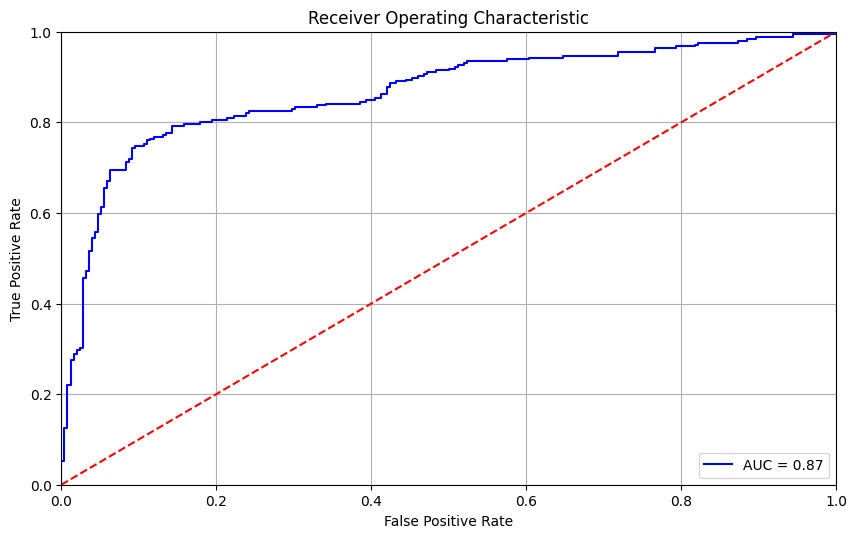

In [130]:
evaluate_roc(probs, labels)

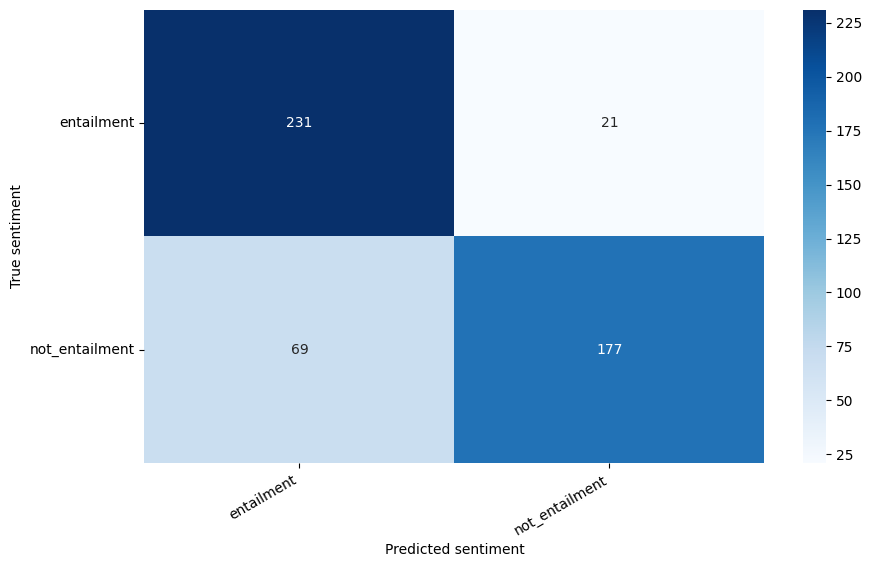

In [131]:
class_names = ['entailment', 'not_entailment']
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### **2.3.2 Trainee Model**

In [132]:
class RteSentenceClassifier(nn.Module):
    """
    Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(RteSentenceClassifier, self).__init__()

        D_in, H, H1, D_out = 768, 512, 256, 2

        self.bert = model.bert
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.SELU(),
            nn.Dropout(),
            nn.Linear(H, H1),
            nn.SELU(),
            nn.Dropout(),
            nn.Linear(H1, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        """
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

At forward step we highlight again `outputs[0][:, 0, :]` because this command gets us the information that was received by the `[CLS]` token.

So, we replaced the classifier in the original **BERT**, it's time to train it with freezing the **BERT** weights. The parameters below were voiced by the author of the model in the description on Hugging Face.

In [134]:
rte_classifier = RteSentenceClassifier(freeze_bert=True)

optimizer = AdamW(rte_classifier.parameters(), lr = 2e-5)

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=600,
    num_training_steps=total_steps
)

rte_classifier.to(DEVICE)

RteSentenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [135]:
train_loss, train_accuracy, val_loss, val_accuracy = train(rte_classifier, train_dataloader, eval_dataloader, epochs=epochs, task='RTE')

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   124   |   0.707985   |     -      |     -     |   30.26  
----------------------------------------------------------------------
   1    |    -    |   0.707985   |  0.646141  |   65.93   |   37.36  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   124   |   0.631105   |     -      |     -     |   29.93  
----------------------------------------------------------------------
   2    |    -    |   0.631105   |  0.552318  |   76.11   |   37.08  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

So, we trained the classifier and achieved competitive results (**81.58%**) on the validation data, for more detailed results let's look at the graphs.

In [136]:
train_results_rte = [train_loss, val_loss, train_accuracy, val_accuracy]

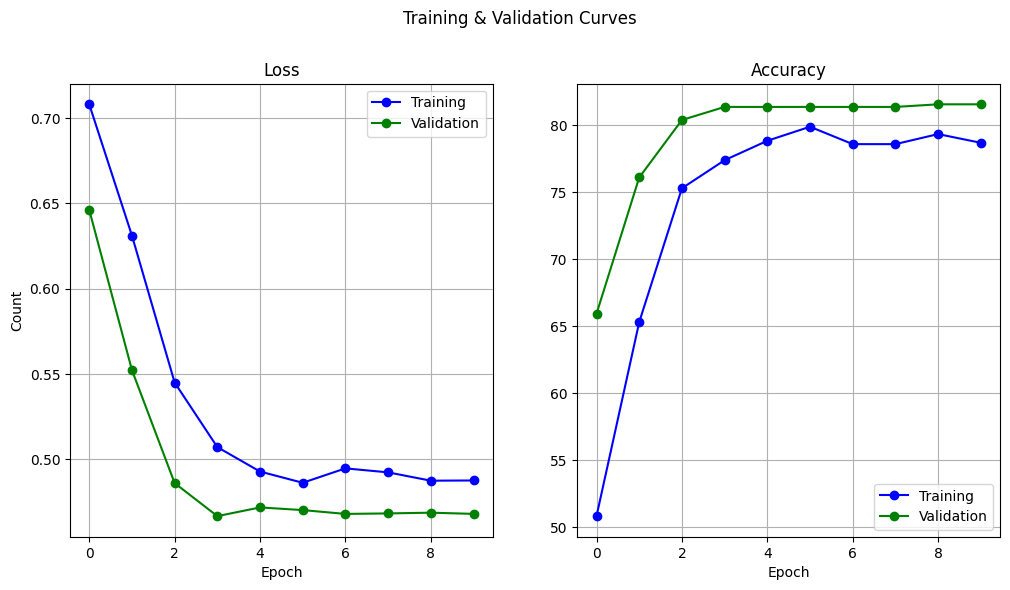

In [137]:
learning_curve(train_results_rte)

Learning plots are quite stable, the learning process is built correctly.

In [138]:
preds, probs, labels, _ = test_logits(rte_classifier, eval_dataloader, metric, task='RTE')

  0%|          | 0/16 [00:00<?, ?it/s]

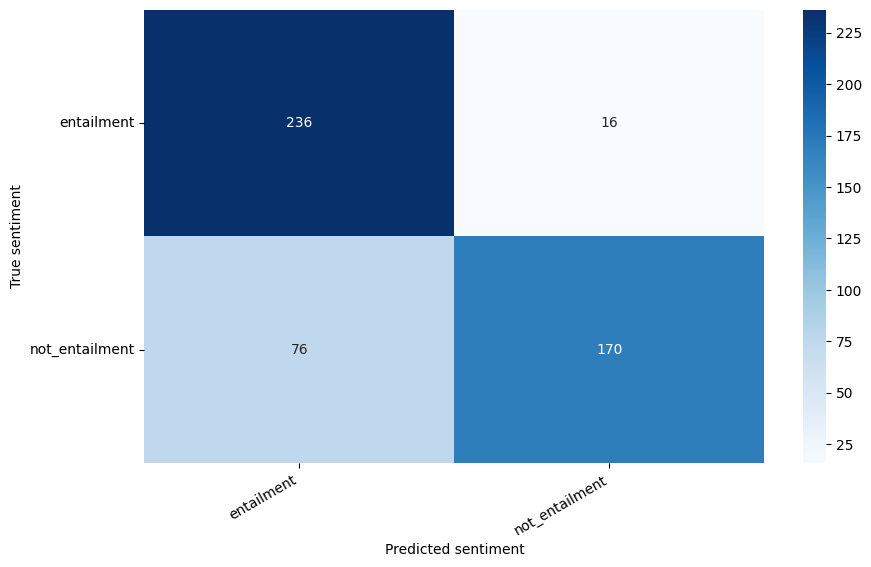

In [139]:
class_names = ['entailment', 'not_entailment']
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

It's not a bad model, but it's too early to stop there! \
Now we will teach not only the classifier, but all weights.

In [140]:
learn_all_rte = RteSentenceClassifier(freeze_bert=False)

optimizer = AdamW(learn_all_rte.parameters(), lr = 1e-5)

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=600,
    num_training_steps=total_steps
)

learn_all_rte.to(DEVICE)

RteSentenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [141]:
train_loss, train_accuracy, val_loss, val_accuracy = train(learn_all_rte, train_dataloader, eval_dataloader, epochs=epochs, task='RTE')

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   124   |   0.727822   |     -      |     -     |   31.82  
----------------------------------------------------------------------
   1    |    -    |   0.727822   |  0.680133  |   52.93   |   39.36  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   124   |   0.655563   |     -      |     -     |   29.95  
----------------------------------------------------------------------
   2    |    -    |   0.655563   |  0.587525  |   78.02   |   37.10  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

We were able to achieve **81%** accuracy on validation set.

In [142]:
train_results_rte = [train_loss, val_loss, train_accuracy, val_accuracy]

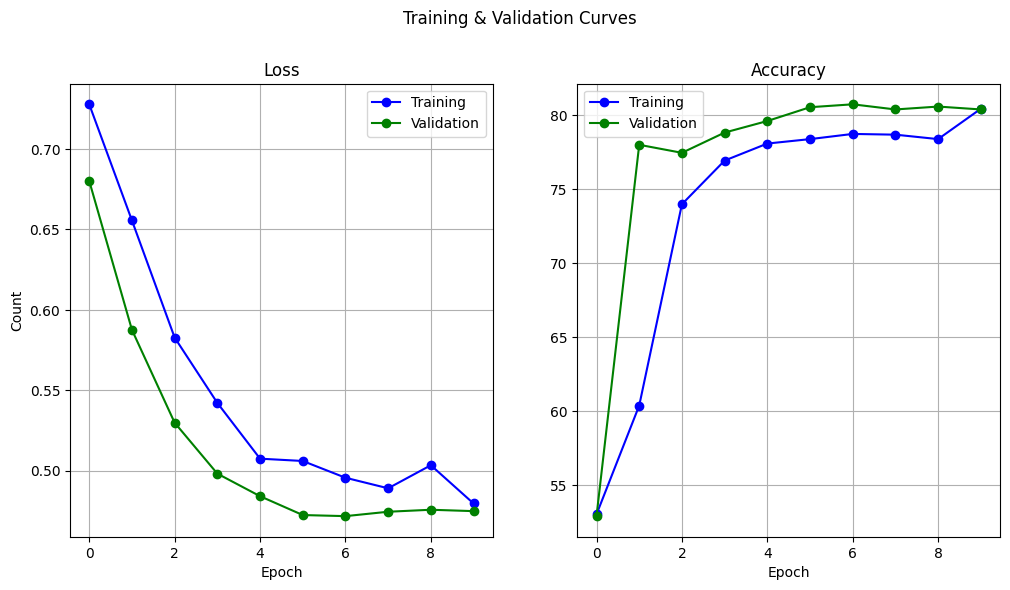

In [143]:
learning_curve(train_results_rte)

The schedule of training looks like as previous plot. Loss drops, metric rises.

In [144]:
preds, probs, labels, _ = test_logits(learn_all_rte, eval_dataloader, metric, task='RTE')

  0%|          | 0/16 [00:00<?, ?it/s]

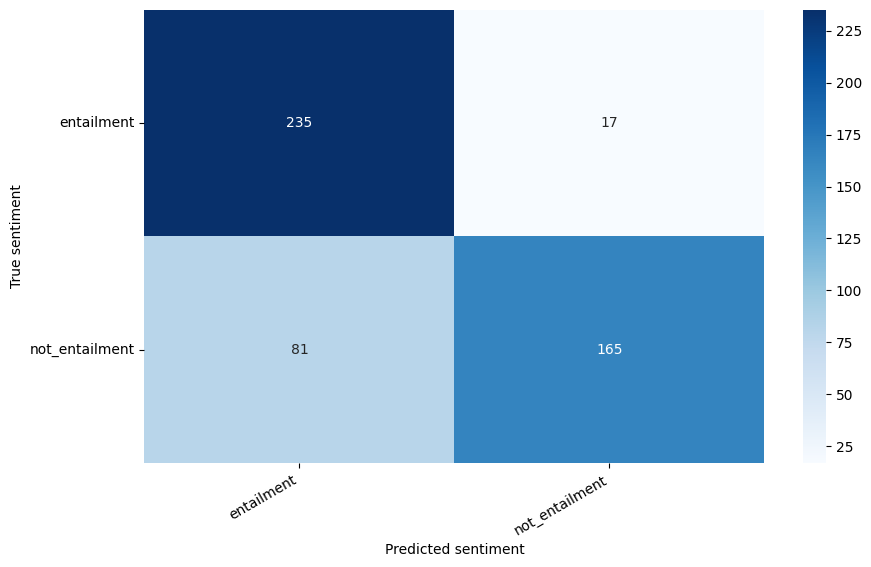

In [145]:
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Now let's look at the value of accuracy metric on the more successful model.

In [146]:
_, probs, labels, metric = test_logits(rte_classifier, test_dataloader, metric, task='RTE')

  0%|          | 0/9 [00:00<?, ?it/s]

In [147]:
print("Trainee model - accuracy score: " , metric.compute()["accuracy"] * 100)

Trainee model - accuracy score:  78.31893165750196


AUC: 0.7441


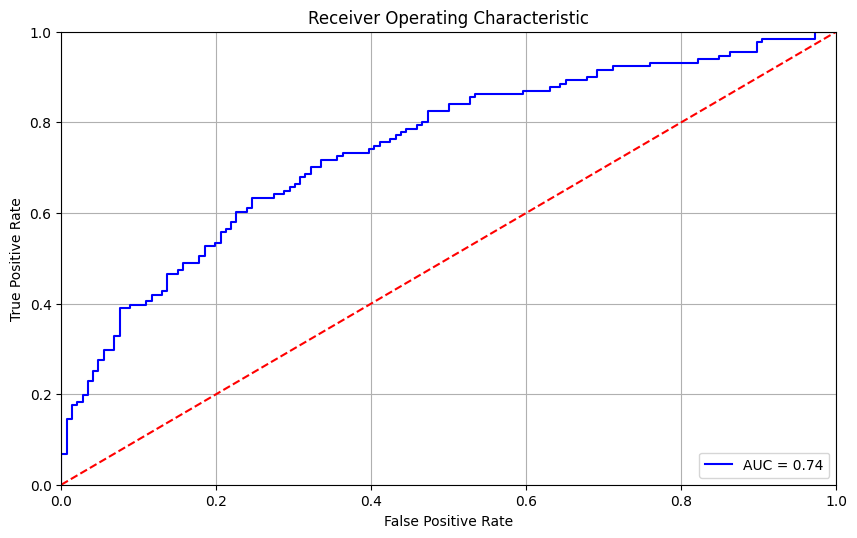

In [148]:
evaluate_roc(probs, labels)

## **2.4 Brief Summary**

I did some experiments on training a classifier for the classification problem on RTE data from the GLUE dataset. Boosting methods showed not quite the expected results, **BERT** with another classifier was better.\
In my tests, the best result of accuracy metric **78%** was shown by **Bert Base** model with modified classifier and unfrozen weights, **Gradient Boosting** methods with "Bert-made" features showed **68%**.

# **3. CoLA**

The last one in today's study is the CoLA dataset. The Corpus of Linguistic Acceptability dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing. 

## **3.1 Data research**

The first thing we need to do is to load the Hugging Face libraries with data and models.

In [ ]:
train_dataset = load_dataset('glue', 'cola', split='train[5%:45]+train[55%:95%]')
valid_dataset = load_dataset('glue', 'cola', split='train[:5%]+train[45%:55%]+train[-5%:]')
test_dataset = load_dataset('glue', 'cola', split='validation')

In [150]:
print("Length of datasets:")
print(f"Train: {len(train_dataset)}", f"Valid: {len(valid_dataset)}", f"Test:  {len(test_dataset)}", sep = '\n')

Length of datasets:
Train: 6840
Valid: 1711
Test:  1043


For convenient analysis of the sentences, let's translate the data into a DataFrame.

In [151]:
df_train = dt_to_pd(train_dataset)
df_valid = dt_to_pd(valid_dataset)
df_test = dt_to_pd(test_dataset)

In [152]:
data_nums = [df_train, df_valid, df_test]

In [153]:
df_train.sample(10)

,sentence,label,idx
1276,The hardest that it ever snowed was last Janua...,acceptable,1704
6415,What Mary did with Bill was sing a song.,acceptable,7698
3544,Fred knows which politician for Karen to vote ...,unacceptable,4827
4932,What is it likely for Beth to have bought at t...,acceptable,6215
4668,I ordered that John drink his beer.,acceptable,5951
6325,Whom left Bill.,unacceptable,7608
6723,"Medea was happy, because she had got the highe...",acceptable,8006
6409,I worked on Sunday in the city on that project...,acceptable,7692
3094,The weather is lovely today.,acceptable,3522
1425,"Him, they let him go yesterday.",acceptable,1853


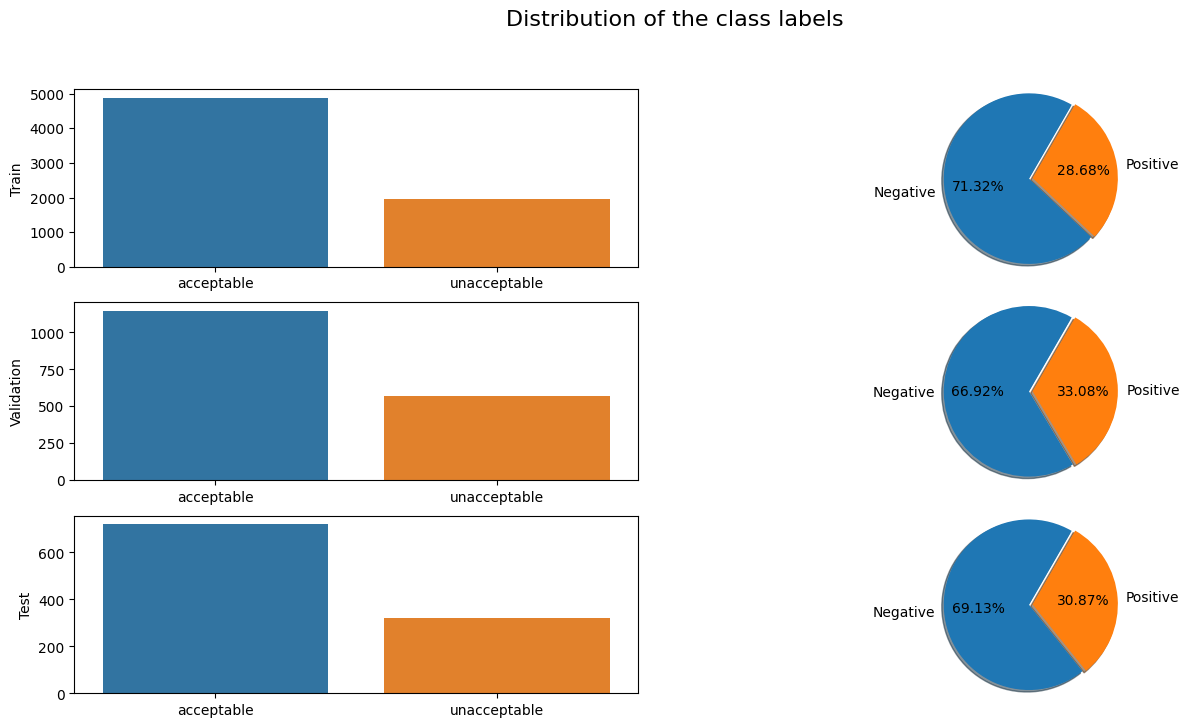

In [154]:
class_balances(data_nums)

Our classes are unbalanced, which means that we may get unrepresentative data and not valid classifier results.

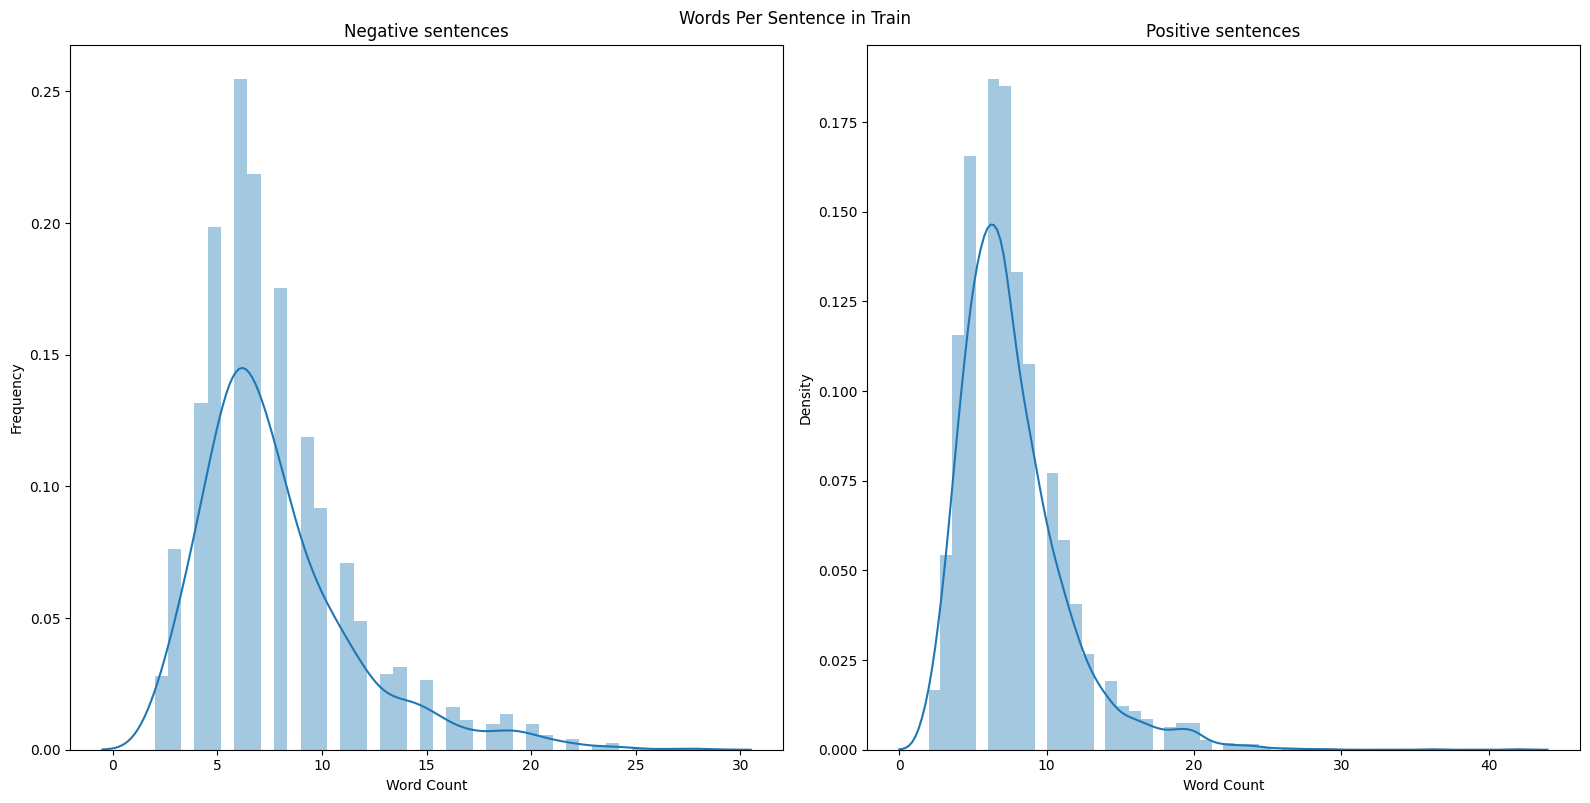

In [155]:
word_number(df_train[df_train['label'] == 'unacceptable']['sentence'],
            df_train[df_train['label'] == 'acceptable']['sentence'])

According to the distribution of the number of words in the sentences corresponding to the different classes, we can notice that most of the sentences in train data don't exceed 20 characters.

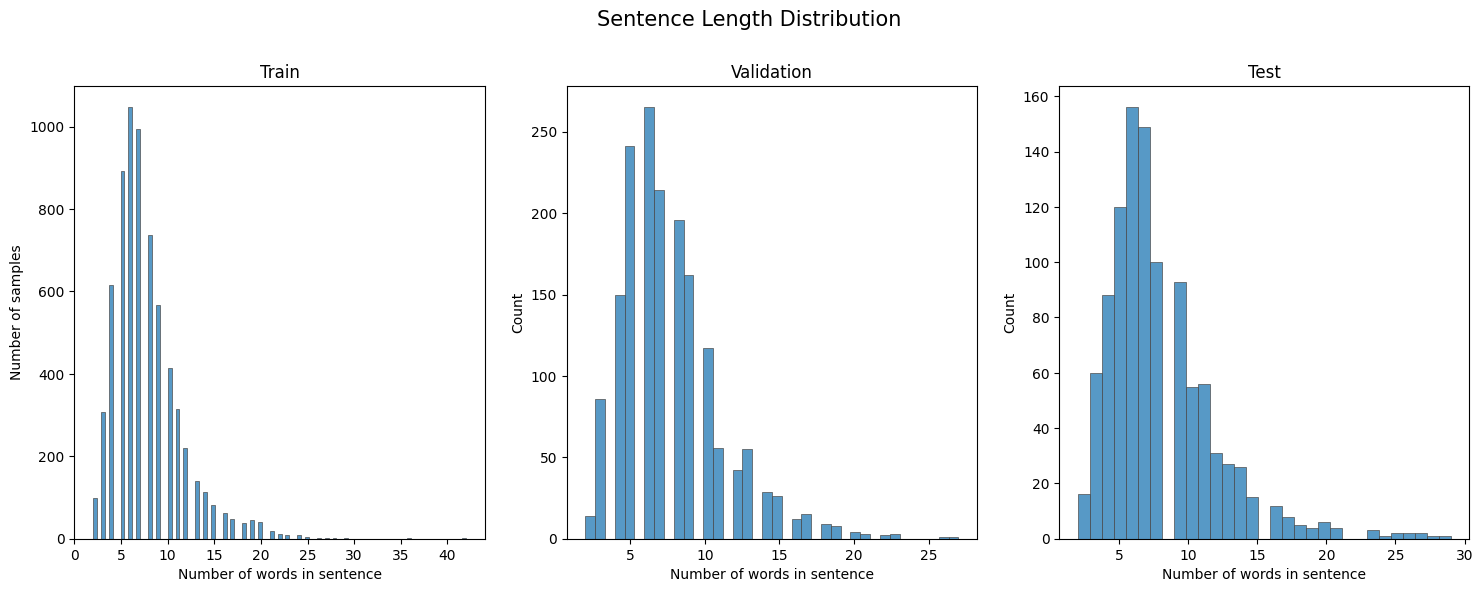

In [156]:
words_in_sentences(data_nums)

In the given train, validation and test data sentences of up to 20 words have the advantage.

In [157]:
max_len = max_sentence_len(data_nums)
print("Max sentence length:", max_len)

Max sentence length: 42


Maximum length will be required for tokenizing sentences. The model can only accept fixed length sentences as input, we will add short sentences with `<PAD>`.

## **3.2 First Approach**



+ The first approach is to apply the `Trainer` API to fine-tune the loaded model. The API provides a convenient quality control interface for training the model.
+ In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because the model has a specific, fixed vocabulary and the BERT tokenizer has a particular way of handling out-of-vocabulary words.
+ In this point I took [Bert Base Uncased](https://huggingface.co/bert-base-uncased) as a pre-trained model. On CoLA it reaches 52%.

In [158]:
from transformers import TrainingArguments, Trainer, BertTokenizer, BertForSequenceClassification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

In [160]:
metric = load_metric('glue', 'cola')

Important note, **Matthew's correlation** coefficient is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform this specific task.

In [161]:
all_data = [train_dataset, valid_dataset, test_dataset] 

In [162]:
def preprocess_cola(data):
    """
    Correcting data for model input
    @params data(list): array containing all parts [train, val, test] of the dataset
    """
    data = data.remove_columns(["idx", "token_type_ids", "sentence"])
    data = data.rename_column("label", "labels")
    data = data.with_format("torch")
    return data

In [163]:
train_enc, valid_enc, test_enc = map(preprocess_cola, list(item.map(encode, batched=True) for item in all_data))

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Now that our data have been reduced to the required form, we can see what the data description consists of:

In [164]:
train_enc.features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'labels': ClassLabel(num_classes=2, names=['unacceptable', 'acceptable'], id=None)}

In [165]:
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_TEST = 8

In [166]:
metric_name = "matthews_correlation"
model_name = "bert-base-uncased"
task = "cola"

In [167]:
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=BATCH_SIZE_TRAIN,
    per_device_eval_batch_size=BATCH_SIZE_TEST,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [168]:
def compute_metrics(eval_pred):
    """
    Preprocess for feeding into a metric function.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

After announcing all the `TrainingArguments`, we are ready to make the announcement of `Trainer`.

In [169]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_enc,
    eval_dataset=valid_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Let's fine-tune our model by just calling the `train` method:

In [170]:
trainer.train()

***** Running training *****
  Num examples = 6840
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2140
***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8
Saving model checkpoint to bert-base-uncased-finetuned-cola/checkpoint-428
Configuration saved in bert-base-uncased-finetuned-cola/checkpoint-428/config.json


{'eval_loss': 0.5196276903152466, 'eval_matthews_correlation': 0.47663357071065243, 'eval_runtime': 13.0089, 'eval_samples_per_second': 131.525, 'eval_steps_per_second': 16.45, 'epoch': 1.0}


Model weights saved in bert-base-uncased-finetuned-cola/checkpoint-428/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-cola/checkpoint-428/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-cola/checkpoint-428/special_tokens_map.json


{'loss': 0.4571, 'learning_rate': 2.2990654205607477e-05, 'epoch': 1.17}


***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8
Saving model checkpoint to bert-base-uncased-finetuned-cola/checkpoint-856
Configuration saved in bert-base-uncased-finetuned-cola/checkpoint-856/config.json


{'eval_loss': 0.7018304467201233, 'eval_matthews_correlation': 0.502496371677343, 'eval_runtime': 13.4511, 'eval_samples_per_second': 127.201, 'eval_steps_per_second': 15.909, 'epoch': 2.0}


Model weights saved in bert-base-uncased-finetuned-cola/checkpoint-856/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-cola/checkpoint-856/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-cola/checkpoint-856/special_tokens_map.json


{'loss': 0.2232, 'learning_rate': 1.598130841121495e-05, 'epoch': 2.34}


***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8
Saving model checkpoint to bert-base-uncased-finetuned-cola/checkpoint-1284
Configuration saved in bert-base-uncased-finetuned-cola/checkpoint-1284/config.json


{'eval_loss': 1.0723140239715576, 'eval_matthews_correlation': 0.5017208677275001, 'eval_runtime': 13.0791, 'eval_samples_per_second': 130.819, 'eval_steps_per_second': 16.362, 'epoch': 3.0}


Model weights saved in bert-base-uncased-finetuned-cola/checkpoint-1284/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-cola/checkpoint-1284/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-cola/checkpoint-1284/special_tokens_map.json


{'loss': 0.1328, 'learning_rate': 8.971962616822429e-06, 'epoch': 3.5}


***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8
Saving model checkpoint to bert-base-uncased-finetuned-cola/checkpoint-1712
Configuration saved in bert-base-uncased-finetuned-cola/checkpoint-1712/config.json


{'eval_loss': 1.1662747859954834, 'eval_matthews_correlation': 0.5049968835049619, 'eval_runtime': 13.0899, 'eval_samples_per_second': 130.711, 'eval_steps_per_second': 16.348, 'epoch': 4.0}


Model weights saved in bert-base-uncased-finetuned-cola/checkpoint-1712/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-cola/checkpoint-1712/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-cola/checkpoint-1712/special_tokens_map.json


{'loss': 0.0706, 'learning_rate': 1.9626168224299064e-06, 'epoch': 4.67}


***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8
Saving model checkpoint to bert-base-uncased-finetuned-cola/checkpoint-2140
Configuration saved in bert-base-uncased-finetuned-cola/checkpoint-2140/config.json


{'eval_loss': 1.1668989658355713, 'eval_matthews_correlation': 0.5382278239205276, 'eval_runtime': 13.0217, 'eval_samples_per_second': 131.396, 'eval_steps_per_second': 16.434, 'epoch': 5.0}


Model weights saved in bert-base-uncased-finetuned-cola/checkpoint-2140/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-cola/checkpoint-2140/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-cola/checkpoint-2140/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 744.3222, 'train_samples_per_second': 45.948, 'train_steps_per_second': 2.875, 'train_loss': 0.20982994052851311, 'epoch': 5.0}


TrainOutput(global_step=2140, training_loss=0.20982994052851311, metrics={'train_runtime': 744.3222, 'train_samples_per_second': 45.948, 'train_steps_per_second': 2.875, 'train_loss': 0.20982994052851311, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one).

In [171]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1711
  Batch size = 8


{'eval_loss': 1.1668989658355713, 'eval_matthews_correlation': 0.5382278239205276, 'eval_runtime': 13.1252, 'eval_samples_per_second': 130.36, 'eval_steps_per_second': 16.305, 'epoch': 5.0}


{'epoch': 5.0,
 'eval_loss': 1.1668989658355713,
 'eval_matthews_correlation': 0.5382278239205276,
 'eval_runtime': 13.1252,
 'eval_samples_per_second': 130.36,
 'eval_steps_per_second': 16.305}

`Trainer` API gave us **53.82%** matthews correlation score on validation set.

## **3.3 Another Approach**

+ The second approach consists of training the classifier as a neural network by back propagation of error. 
+ We change classifier and will unfreeze it is. At the end we will unfreeze the weights of the whole model to throw the gradients to the first layer.
+ In this point I left the model from the first approach.

In [172]:
train_dataloader = DataLoader(
    train_enc, shuffle=True, batch_size = BATCH_SIZE_TRAIN
    )

eval_dataloader = DataLoader(
    valid_enc, batch_size = BATCH_SIZE_TEST
    )

test_dataloader = DataLoader(
    test_enc, batch_size = BATCH_SIZE_TEST
)

In [173]:
class ColaSentenceClassifier(nn.Module):
    """
    Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(ColaSentenceClassifier, self).__init__()

        D_in, H, D_out = 768, 512, 2

        self.bert = model.bert
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.SELU(),
            nn.Dropout(),
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        """
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        logits = self.classifier(last_hidden_state_cls)

        return logits

At forward step we highlight again `outputs[0][:, 0, :]` because this command gets us the information that was received by the `[CLS]` token.

So, we replaced the classifier in the original **BERT**, it's time to train it with freezing the **BERT** weights. The parameters below were voiced by the author of the model in the description on `Hugging Face`. 

In [174]:
cola_classifier = ColaSentenceClassifier(freeze_bert=True)

optimizer = AdamW(cola_classifier.parameters(), lr = 3e-5, eps = 1e-8)

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

cola_classifier.to(DEVICE)

ColaSentenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [175]:
train_loss, train_accuracy, val_loss, val_accuracy = train(cola_classifier, train_dataloader, eval_dataloader, epochs=epochs)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.066494   |     -      |     -     |   33.92  
   1    |   400   |   0.040058   |     -      |     -     |   33.84  
   1    |   427   |   0.012822   |     -      |     -     |   4.51   
----------------------------------------------------------------------
   1    |    -    |   0.050755   |  1.207389  |   80.07   |   85.23  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   200   |   0.028258   |     -      |     -     |   33.95  
   2    |   400   |   0.037211   |     -      |     -     |   33.62  
   2    |   427   |   0.045821   |     -      |     -     |   4.51   
-----------------------------------------------------------------

The model achieved **80%** matthews correlation score on the validation set. Let's look at the learning curve. 

In [176]:
train_results_cola = [train_loss, val_loss, train_accuracy, val_accuracy]

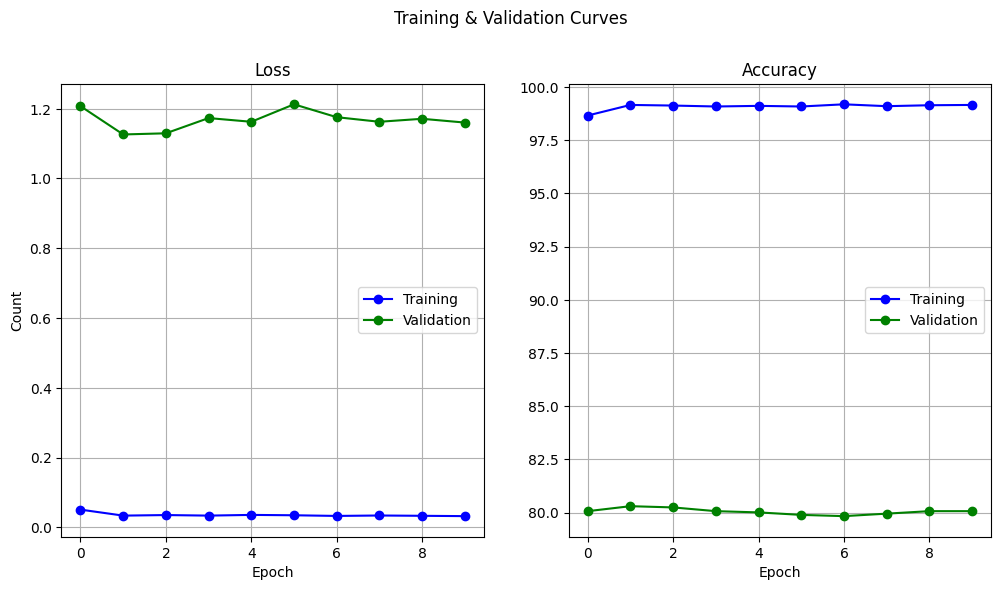

In [177]:
learning_curve(train_results_cola)

Loss on the training and validation data differs by several times but the main trend of the falling loss is seen.

In [178]:
preds, probs, labels, _ = test_logits(cola_classifier, eval_dataloader, metric)

  0%|          | 0/214 [00:00<?, ?it/s]

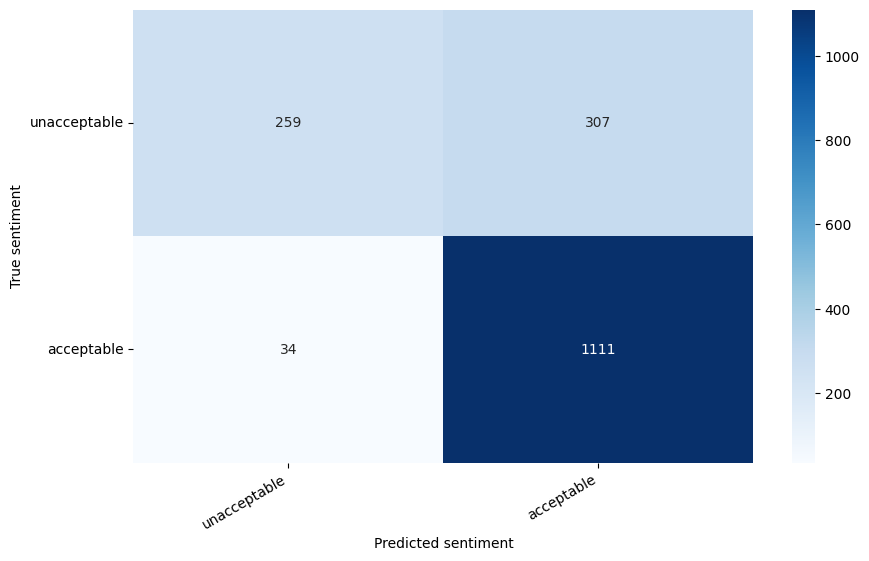

In [179]:
class_names = ['unacceptable', 'acceptable']
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Now we will teach not only the classifier, but all weights.

In [180]:
learn_all_cola = ColaSentenceClassifier(freeze_bert=False)

optimizer = AdamW(learn_all_cola.parameters(), lr = 3e-5, eps=1e-8)

epochs = 10

total_steps = len(train_dataloader) * epochs

scheduler = get_scheduler(
    "linear",
    optimizer = optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

learn_all_cola.to(DEVICE)

ColaSentenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [181]:
train_loss, train_accuracy, val_loss, val_accuracy = train(learn_all_cola, train_dataloader, eval_dataloader, epochs=epochs)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   200   |   0.057993   |     -      |     -     |   33.90  
   1    |   400   |   0.028566   |     -      |     -     |   33.82  
   1    |   427   |   0.027999   |     -      |     -     |   4.55   
----------------------------------------------------------------------
   1    |    -    |   0.042350   |  1.244696  |   80.25   |   85.18  
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   200   |   0.028707   |     -      |     -     |   34.33  
   2    |   400   |   0.038873   |     -      |     -     |   42.99  
   2    |   427   |   0.057776   |     -      |     -     |   6.31   
-----------------------------------------------------------------

The model achieved **80.37%** matheus correlation score on the validation set. Let's look at the learning curve.

In [182]:
train_results_cola = [train_loss, val_loss, train_accuracy, val_accuracy]

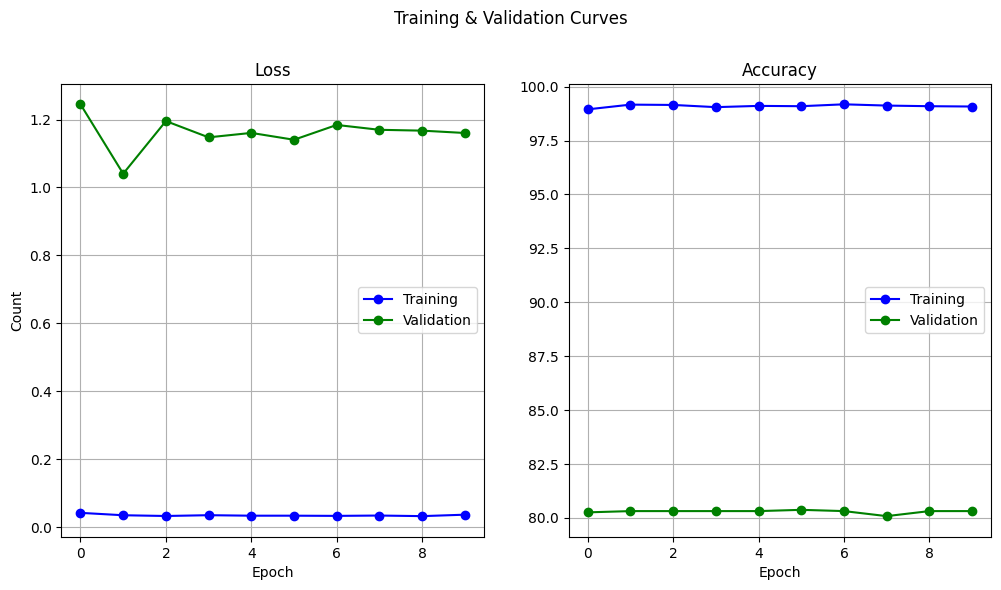

In [183]:
learning_curve(train_results_cola)

Loss on the training and validation data differs by several times, but the learning process looks stable.

In [184]:
preds, probs, labels, _ = test_logits(learn_all_cola, eval_dataloader, metric)

  0%|          | 0/214 [00:00<?, ?it/s]

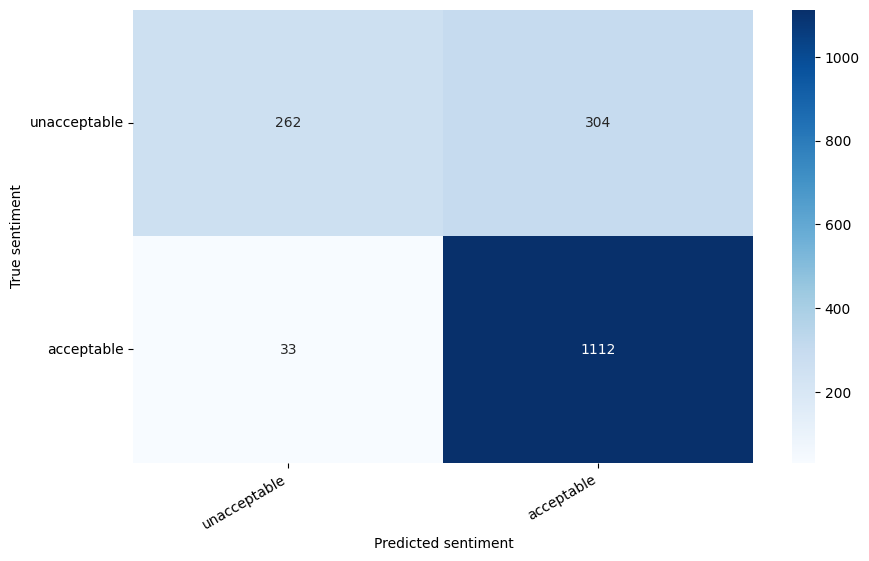

In [185]:
cm = confusion_matrix(labels, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Now let's look at the value of the metric on the more successful model.

In [186]:
_, probs, labels, metric = test_logits(learn_all_cola, test_dataloader, metric)

  0%|          | 0/131 [00:00<?, ?it/s]

In [187]:
print("Trainee model - matthews correlation score: " , metric.compute()["matthews_correlation"] * 100)

Trainee model - matthews correlation score:  53.69728724735627


AUC: 0.8547


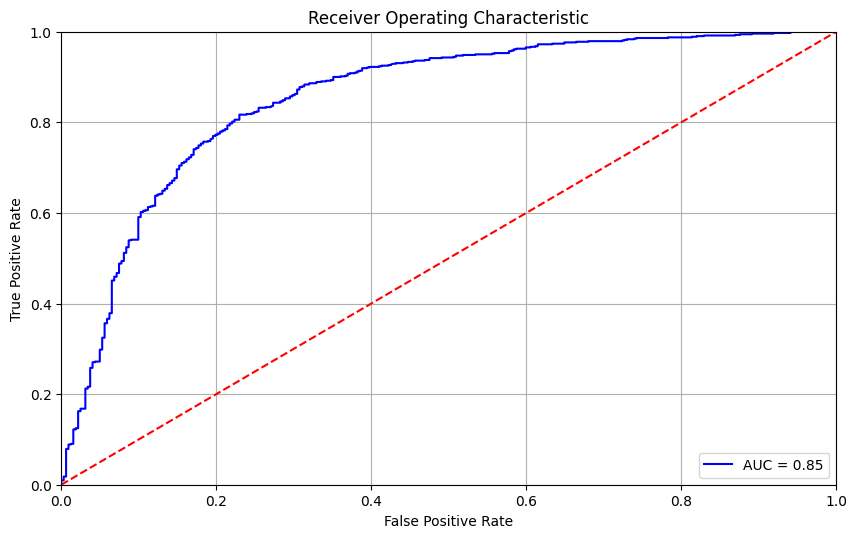

In [188]:
evaluate_roc(probs, labels)

### **3.3 Brief Summary**

I did some experiments on training a classifier for the classification problem on CoLA data from the `GLUE` dataset. Цe looked at the technique of applying the built-in `Trainer` API and then trained the classifier ourselves.
In my tests, the best result of matthews correlation metric **53.69%** was shown by **Bert Base Uncased** model with modified classifier and unfrozen weights, **Trainer** API showed **52.82%**

# **4. Results**

We looked at three datasets from **GLUE** and tried to train the classifier on each of them. The research included application of classical machine learning methods (`Logistic Regression`, `SVM`, `Random Forest`), gradient boosting methods (`XGBoost`, `LightGBM`, `CatBoost`), built-in Hugging-Face API `Trainer` for fine-tuning models and training a modified classifier with `nn.module` `Pytorch` interface. 

Each of the methods was evaluated on validation data, and the best in their categories on test data. I was able to show competitive metrics values comparable to those declared.\
Selecting a classifier is a task that has many approaches and must be solved from the conditions of the given data and metrics.

*For myself, I would highlight replacing the classifier and future training it using the `nn.module` in `PyTorch` and `Trainer` API from Hugging-Face.*